# Synthetic Moho Model from Uieda et al. 2017.

Here we attempt to reproduce the simple synthetic Moho inversion from [Uieda et al. 2017:](https://doi.org/10.1093/gji/ggw390) Fast nonlinear gravity inversion in spherical coordinates with application to the South American Moho. They provide functions for creating synthetic Moho topography, which we forward model to create the observed gravity data to use for the inversion.

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import pathlib
import pickle

import numpy as np
import pyproj
import scipy as sp
import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

from invert4geom import (
    cross_validation,
    optimization,
    plotting,
    regional,
    synthetic,
    utils,
)

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

# Recreate synthetic topography 
Here we recreate the synthetic topography model from the paper. We slightly update their code for creating this, and use projected coordinates instead of geographic coordinates, but the models are as similar as possible to the original.

In [2]:
def gaussian2d(x, y, sigma_x, sigma_y, x0=0, y0=0, angle=0.0):
    """
    Taken from https://legacy.fatiando.org/api/utils.html#fatiando.utils.gaussian2d
    which is used in Uieda et al. 2017 paper.
    """
    theta = -1 * angle * np.pi / 180.0
    tmpx = 1.0 / sigma_x**2
    tmpy = 1.0 / sigma_y**2
    sintheta = np.sin(theta)
    costheta = np.cos(theta)
    a = tmpx * costheta + tmpy * sintheta**2
    b = (tmpy - tmpx) * costheta * sintheta
    c = tmpx * sintheta**2 + tmpy * costheta**2
    xhat = x - x0
    yhat = y - y0
    return np.exp(-(a * xhat**2 + 2.0 * b * xhat * yhat + c * yhat**2))

In [3]:
# Make a regular grid inside an area.
# Grid points will be the center of the top of each tesseroid in the model
shape = (40, 50)  # n, e
region_ll = (-50, 50, 10, 70)  # e, n
lon, lat = vd.grid_coordinates(region=region_ll, shape=shape)

relief = (
    -30e3
    + 15e3 * sp.special.erf((lon - 10) / 20)
    - 10e3 * gaussian2d(lat, lon, 10, 15, x0=25, y0=-30)
    + 10e3 * gaussian2d(lat, lon, 15, 20, x0=53, y0=-25)
    - 10e3 * gaussian2d(lat, lon, 3, 3, x0=50, y0=30)
    - 10e3 * gaussian2d(lat, lon, 10, 10, x0=30, y0=25) ** 2
    + 5e3 * gaussian2d(lat, lon, 40, 3, x0=40, y0=40, angle=15)
)

relief = vd.make_xarray_grid((lon, lat), relief, data_names="z").z

# We're choosing the latitude of true scale as the mean latitude of our dataset
projection = pyproj.Proj(proj="merc", lat_ts=lat.mean())

region = vd.project_region(region_ll, projection)

true_moho = vd.project_grid(
    relief,
    projection,
    spacing=50e3,
    # shape=shape,
    # region=region,
    adjust="region",
    # dims=("northing", "easting")
    # dims=("easting", "northing"),
)
coords = vd.grid_coordinates(
    region=region,
    shape=shape,
)

grid = vd.make_xarray_grid(coords, np.ones_like(coords[0]), data_names="z").z
grid = grid.rio.set_spatial_dims("easting", "northing").rio.write_crs("epsg:4326")
true_moho = true_moho.rio.set_spatial_dims("easting", "northing").rio.write_crs(
    "epsg:4326"
)
true_moho = (
    true_moho.rio.reproject_match(grid)
    .drop_vars("spatial_ref")
    .rename({"x": "easting", "y": "northing"})
)
true_moho

<xarray.DataArray 'z' (northing: 40, easting: 50)> Size: 16kB
array([[-45177.24180555, -45239.8727541 , -45340.59051469, ...,
        -15163.35728756, -15114.04947581,             nan],
       [-45340.54674681, -45457.30068595, -45654.65002146, ...,
        -15163.35996064, -15114.05004151,             nan],
       [-45570.38852394, -45772.31140738, -46096.92149987, ...,
        -15163.36986469, -15114.05262762,             nan],
       ...,
       [-44257.97783008, -44080.08182345, -43811.6790295 , ...,
        -12935.36332113, -12317.86449551,             nan],
       [-44338.69346082, -44177.60610815, -43940.63705898, ...,
        -13168.52637362, -12438.51279825,             nan],
       [-44416.56602504, -44277.06688914, -44065.05276873, ...,
        -13388.54999896, -12508.75995656,             nan]])
Coordinates:
  * easting   (easting) float64 400B -4.27e+06 -4.095e+06 ... 4.095e+06 4.27e+06
  * northing  (northing) float64 320B 8.526e+05 1.048e+06 ... 8.265e+06 8.46e+06
Attributes:
    metadata:    Generated by Chain(steps=[('mean',\n              BlockReduc...
    _FillValue:  nan

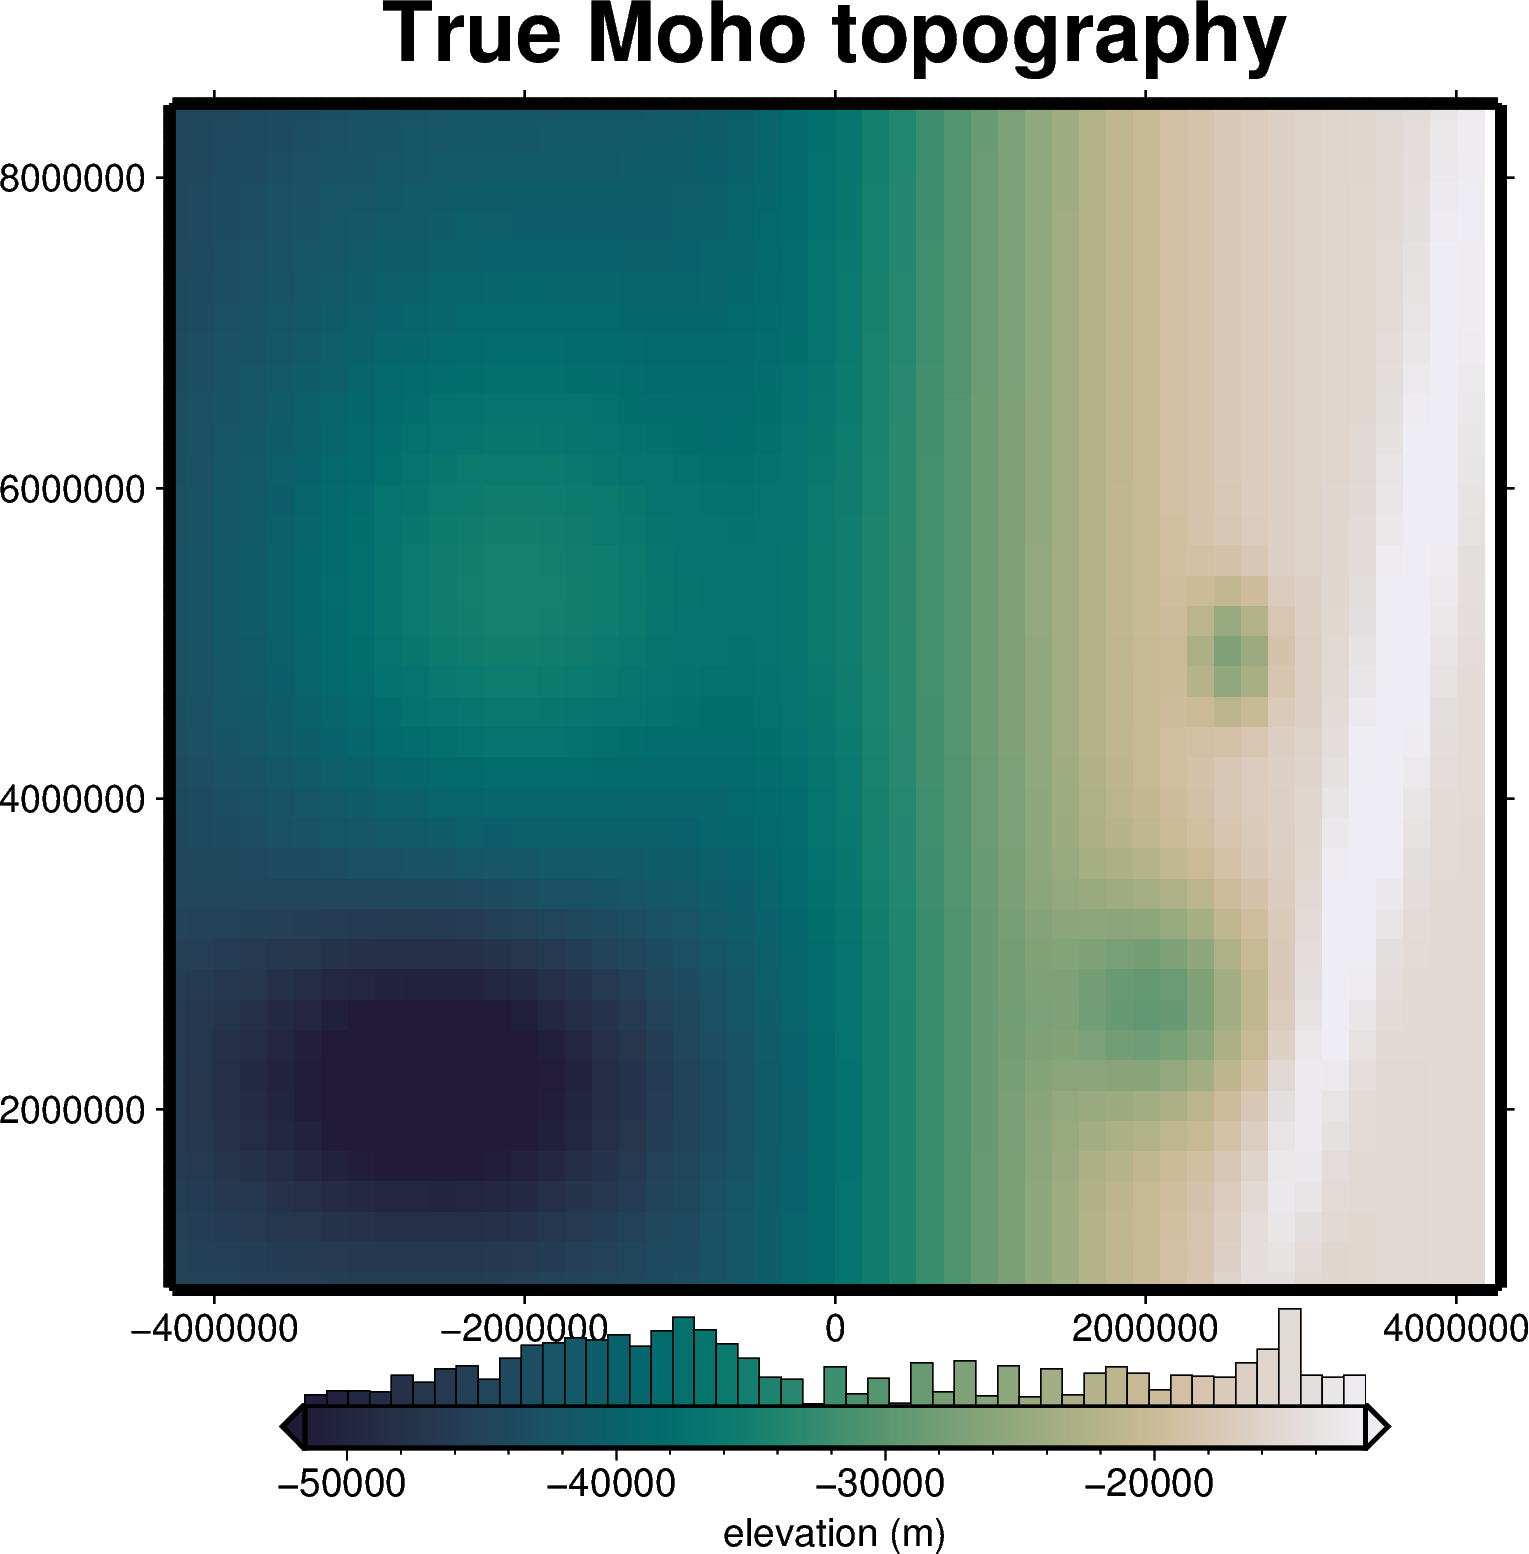

In [4]:
fig = maps.plot_grd(
    true_moho,
    fig_height=10,
    title="True Moho topography",
    hist=True,
    cmap="rain",
    reverse_cpt=True,
    cbar_yoffset=1,
    cbar_label="elevation (m)",
    robust=True,
    frame=["nSWe", "xaf10000", "yaf10000"],
)
fig.show()

# Observed gravity data
We can know forward-model the effects of this topography and add some noise to make a synthetic observed gravity dataset.

MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


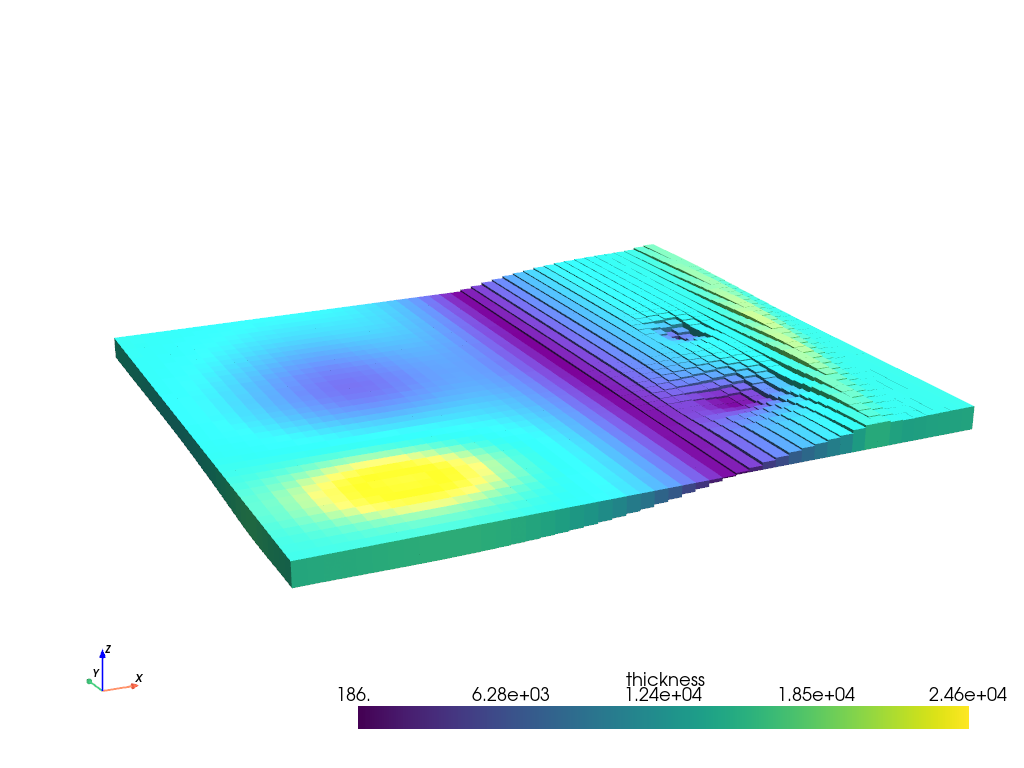

In [5]:
# Define the reference level (height in meters).
# This is the Moho depth of the Normal Earth
true_zref = -30e3

# The density contrast is negative if the relief is below the reference
true_density_contrast = 400
density_grid = xr.where(
    true_moho >= true_zref, true_density_contrast, -true_density_contrast
)

# make prism layer
prisms = utils.grids_to_prisms(true_moho, true_zref, density=density_grid)

plotting.show_prism_layers(
    prisms,
    color_by="thickness",
    log_scale=False,
    zscale=20,
    backend="static",
)

In [6]:
spacing, region, _, _, _ = polar_utils.get_grid_info(true_moho)
spacing, region

(195062.062538, (-4269692.84793, 4269692.84793, 852619.296672, 8460039.73566))

In [7]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=50e3,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

# resample to half spacing
grav_df = cross_validation.resample_with_test_points(spacing, grav_df, region)
grav_df

grav_df["gravity_anomaly"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
# contaminate gravity with random noise
grav_df["gravity_anomaly"], stddev = synthetic.contaminate(
    grav_df.gravity_anomaly,
    stddev=5,
    percent=False,
    seed=0,
)

grav_df.describe()

  0%|          | 0/7031 [00:00<?, ?it/s]

INFO:invert4geom:Standard deviation used for noise: [5.0]


,northing,easting,upward,gravity_anomaly
count,7.031000e+03,7.031000e+03,7.031000e+03,7031.000000
mean,4.656330e+06,-2.585609e-10,5.000000e+04,-33.485446
std,2.224208e+06,2.493141e+06,6.285309e-12,176.189841
min,8.526193e+05,-4.269693e+06,5.000000e+04,-383.492474
25%,2.705709e+06,-2.134846e+06,5.000000e+04,-170.164560
50%,4.656330e+06,0.000000e+00,5.000000e+04,-93.256424
75%,6.606950e+06,2.134846e+06,5.000000e+04,134.484639
max,8.460040e+06,4.269693e+06,5.000000e+04,300.953412


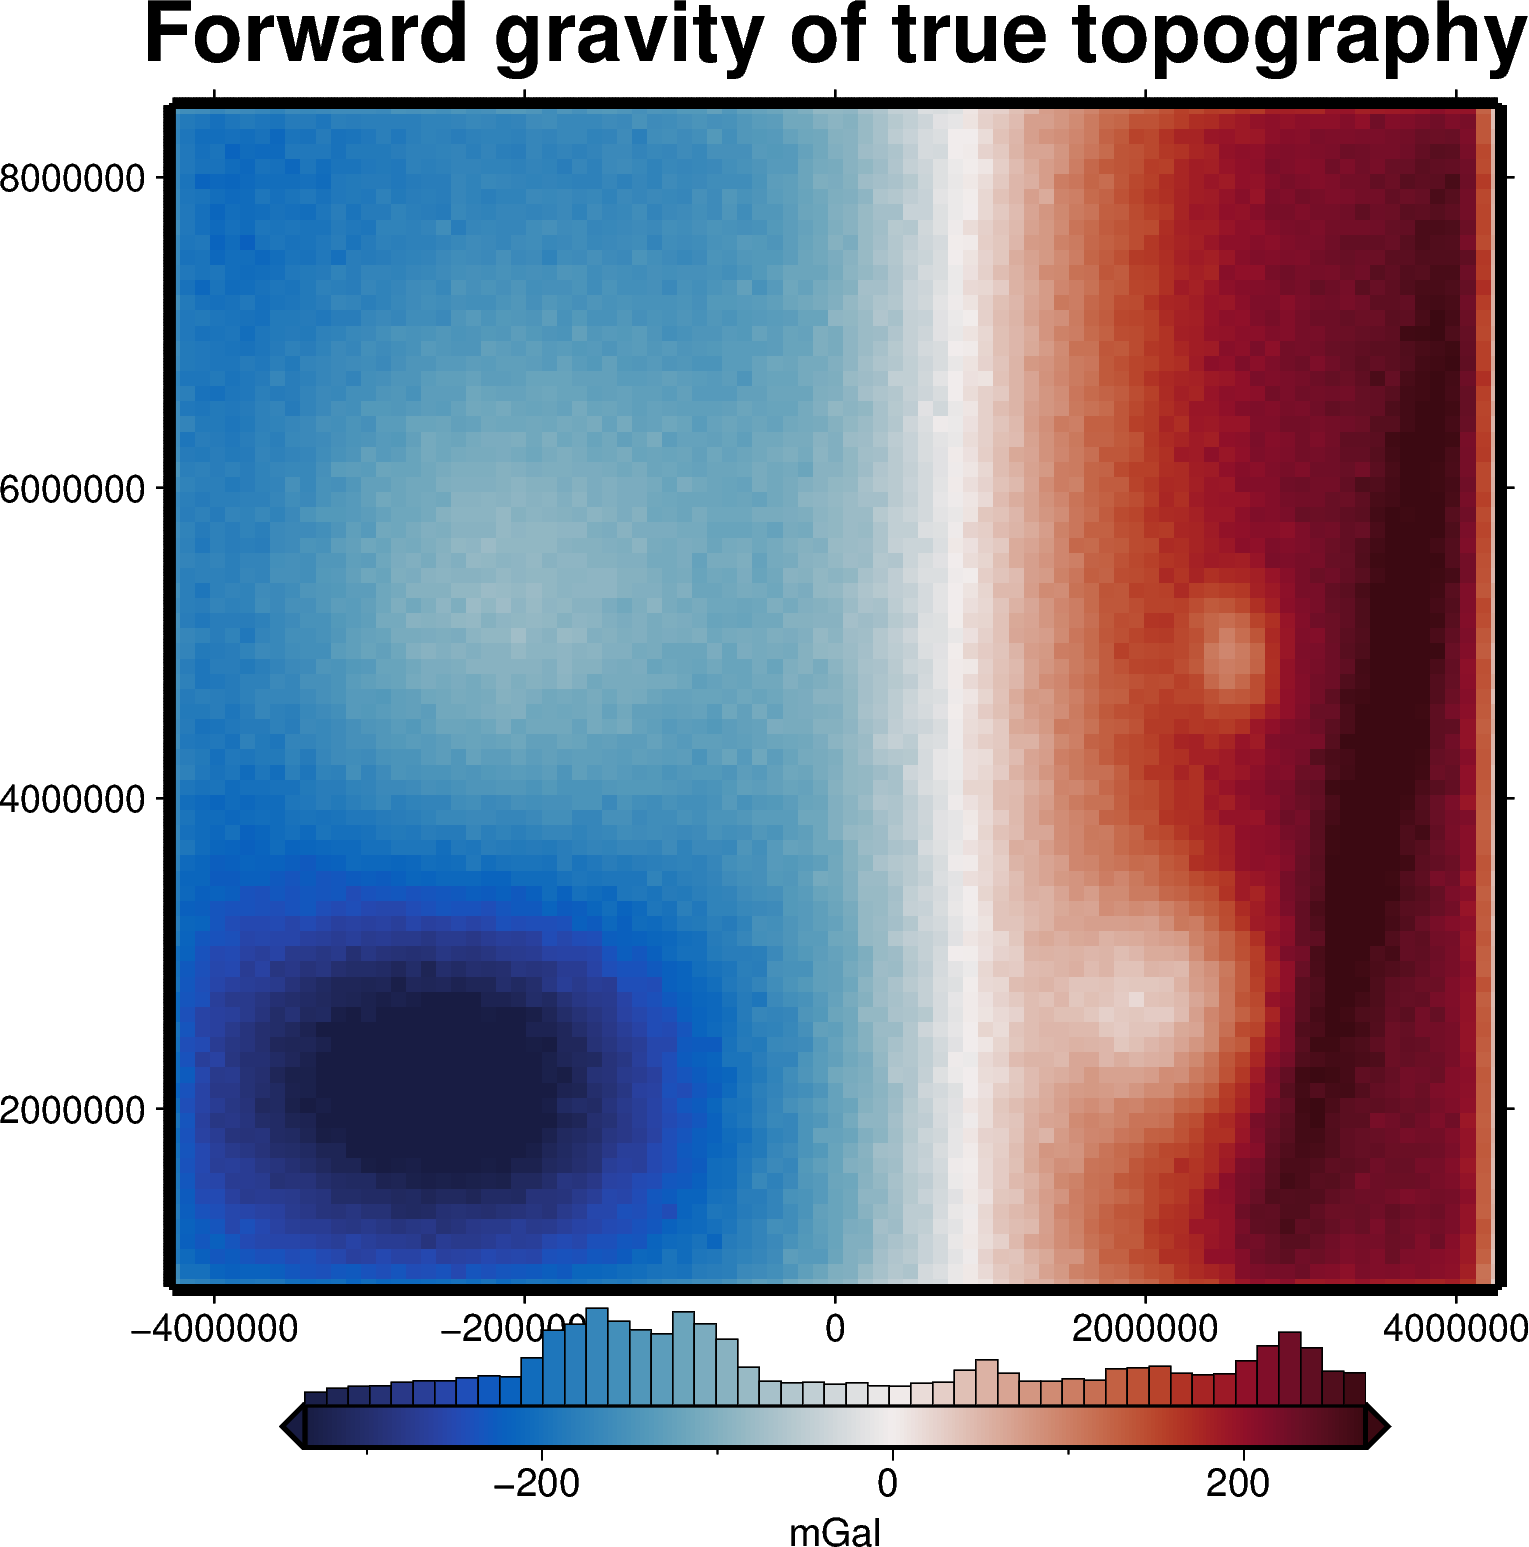

In [8]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    fig_height=10,
    title="Forward gravity of true topography",
    hist=True,
    cbar_yoffset=1,
    cmap="balance+h0",
    cbar_label="mGal",
    robust=True,
    frame=["nSWe", "xaf10000", "yaf10000"],
)
fig.show()

In [9]:
true_zref, true_density_contrast

(-30000.0, 400)

# Starting model
Following the paper's approach, we create a starting model which uses the true values of the density contrast and reference level for the Moho. This is used during the damping parameter cross-validation.

In [10]:
# create flat topography grid with a constant height equal the mean of the starting
# topography (zref)
zref = true_zref
density_contrast = true_density_contrast
starting_topography = xr.full_like(true_moho, zref)

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    starting_topography >= zref, density_contrast, -density_contrast
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)

# since our starting model is flat, the starting gravity is 0
grav_df["starting_gravity"] = 0

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and set
# it to 0
grav_df = regional.regional_separation(
    method="constant",
    constant=0,
    grav_df=grav_df,
)
grav_df

,northing,easting,test,upward,gravity_anomaly,starting_gravity,misfit,reg,res
0,8.526193e+05,-4.269693e+06,False,50000.0,-152.062976,0,-152.062976,0,-152.062976
1,8.526193e+05,-4.172654e+06,True,50000.0,-175.360912,0,-175.360912,0,-175.360912
2,8.526193e+05,-4.075616e+06,False,50000.0,-180.137655,0,-180.137655,0,-180.137655
3,8.526193e+05,-3.978577e+06,True,50000.0,-187.583852,0,-187.583852,0,-187.583852
4,8.526193e+05,-3.881539e+06,False,50000.0,-193.926566,0,-193.926566,0,-193.926566
...,...,...,...,...,...,...,...,...,...
7026,8.460040e+06,3.881539e+06,False,50000.0,205.203099,0,205.203099,0,205.203099
7027,8.460040e+06,3.978577e+06,True,50000.0,197.734746,0,197.734746,0,197.734746
7028,8.460040e+06,4.075616e+06,False,50000.0,197.234724,0,197.234724,0,197.234724
7029,8.460040e+06,4.172654e+06,True,50000.0,125.075292,0,125.075292,0,125.075292


# Damping parameter cross validation

## Get individual score

We will perform an inversion with a single damping value and calculate a `score` for it. The grid shows how to `score` is calculated, as the RMS difference between the predicted and observed gravity data.

  0%|          | 0/5231 [00:00<?, ?it/s]

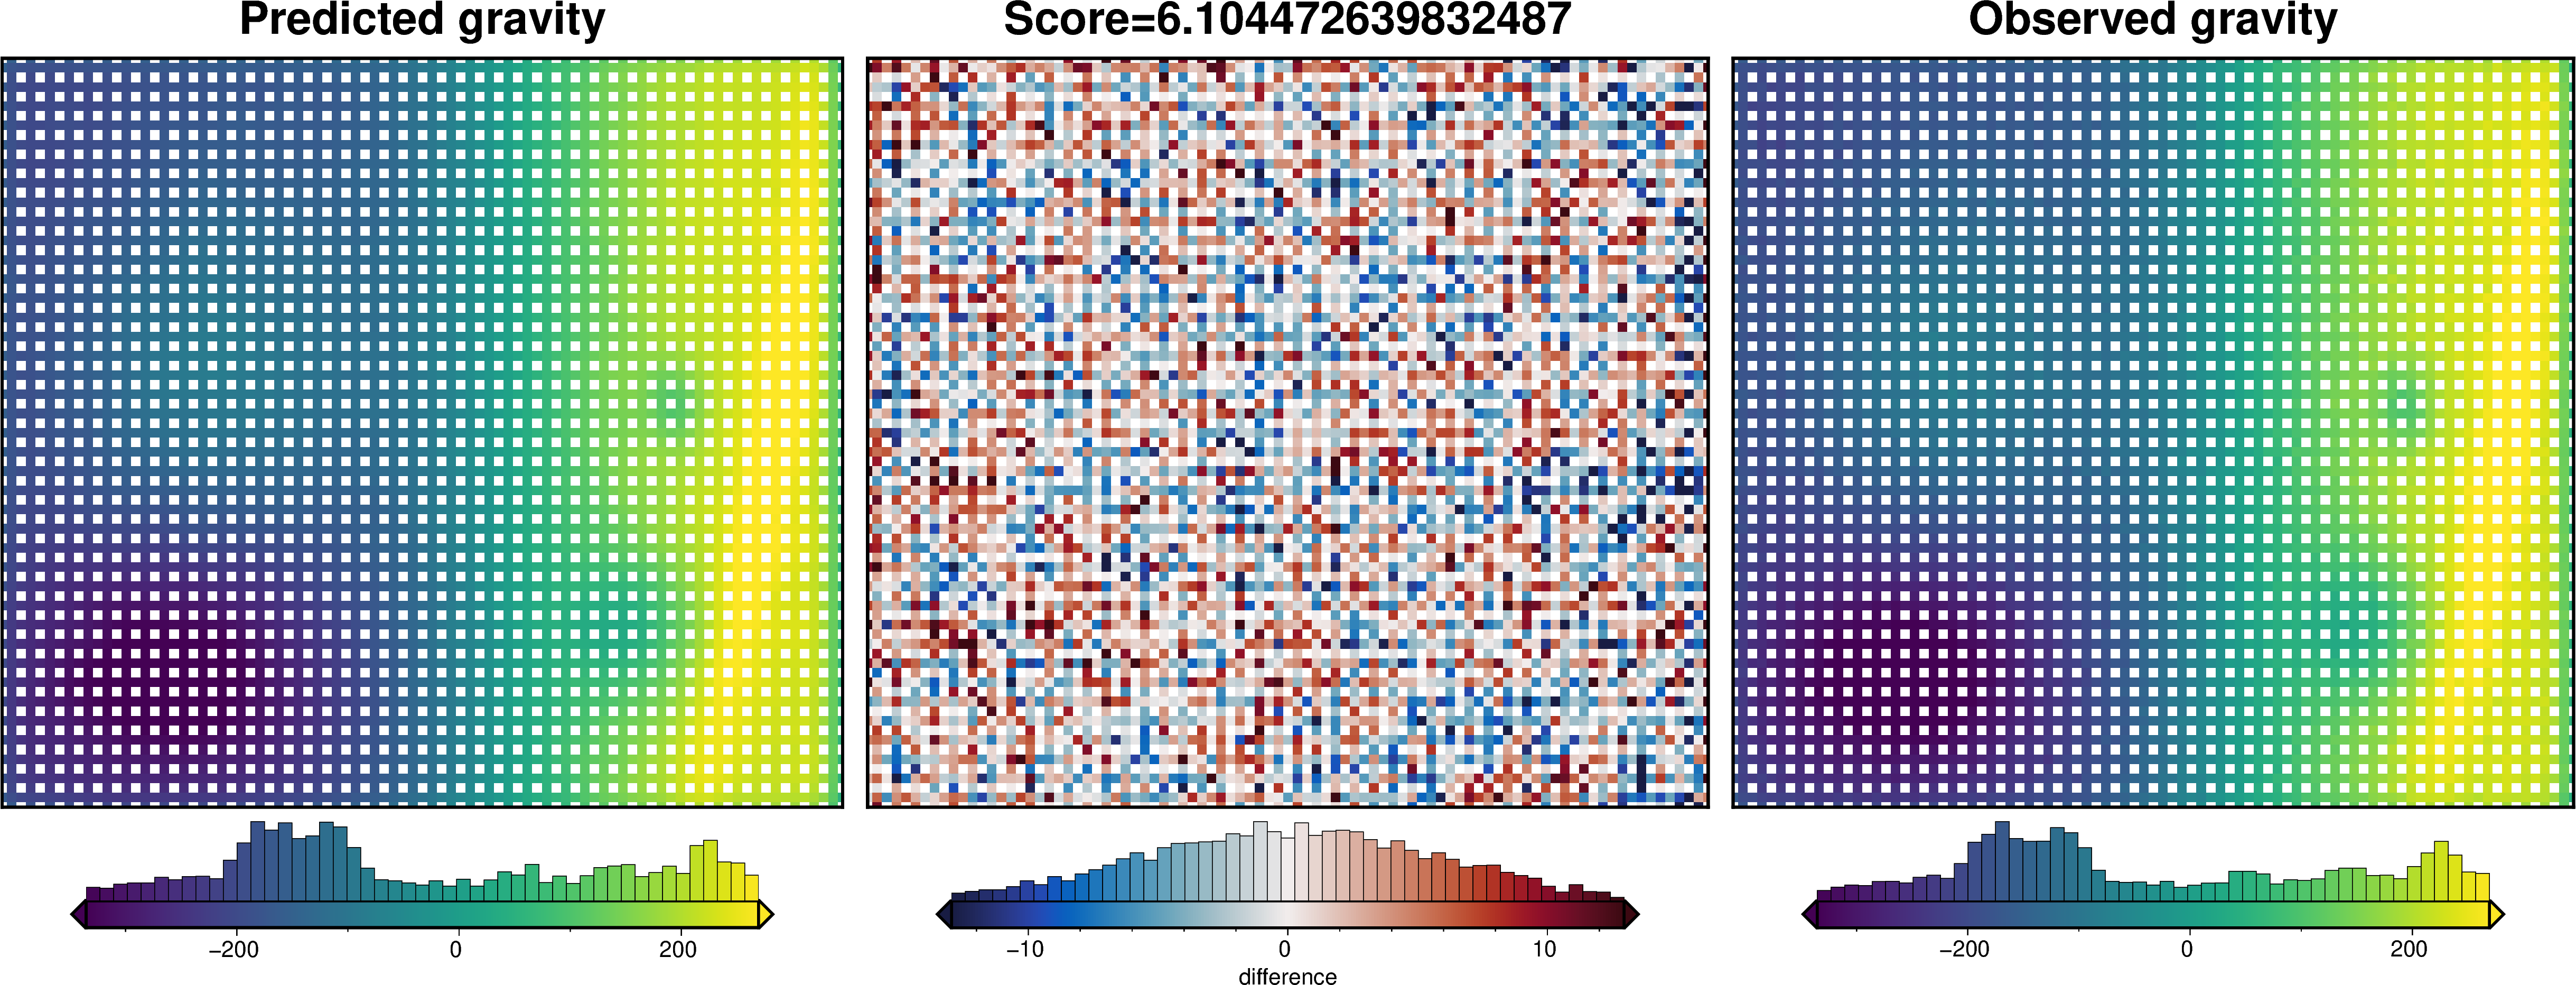

np.float64(6.104472639832487)

In [11]:
# set kwargs to pass to the inversion
kwargs = {
    # set stopping criteria
    "max_iterations": 300,
    "l2_norm_tolerance": 2.2,  # gravity error is 5 mGal or L2-norm of ~2.2
    "delta_l2_norm_tolerance": 1.008,
}

# run inversion, calculate the score, and plot the predicted and observed gravity for
# the testing dataset
score, results = cross_validation.grav_cv_score(
    training_data=grav_df[grav_df.test == False],
    testing_data=grav_df[grav_df.test == True],
    prism_layer=starting_prisms,
    solver_damping=0.01,
    progressbar=True,
    plot=True,
    **kwargs,
)

score

## Cross Validation Optimization

INFO:invert4geom:using 4 startup trials


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 7
INFO:invert4geom:	parameter: {'damping': 0.009919766956964641}
INFO:invert4geom:	scores: [6.0975184753573055]


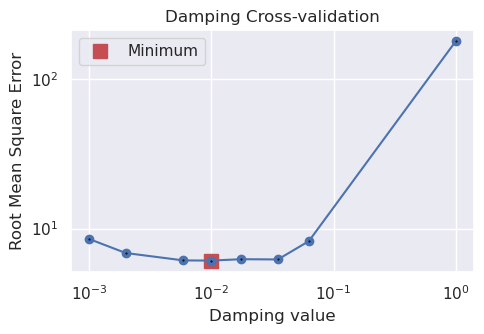

In [12]:
study, inversion_results = optimization.optimize_inversion_damping(
    training_df=grav_df[grav_df.test == False],
    testing_df=grav_df[grav_df.test == True],
    prism_layer=starting_prisms,
    damping_limits=(0.001, 1),
    n_trials=8,
    # grid_search=True,
    # plot_grids=True,
    fname="../tmp/uieda_synthetic_damping_CV",
    **kwargs,
)

In [13]:
# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/uieda_synthetic_damping_CV_study.pickle").open("rb") as f:
    study = pickle.load(f)

# to re-load the inversion results from the saved pickle file
with pathlib.Path("../tmp/uieda_synthetic_damping_CV_results.pickle").open("rb") as f:
    inversion_results = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

In [14]:
best_damping = study.best_params.get("damping")
best_damping

0.009919766956964641

The above plot shows the results of the damping parameter cross validation, and is equivalent to Figure 5e in the paper. The main difference is that we use a optimization approach instead of a grid search. This allows us to find the best value in fewer trials, as the parameter search space is quickly narrowed down. We performed 8 trials, compared to the 16 trials used in the paper.

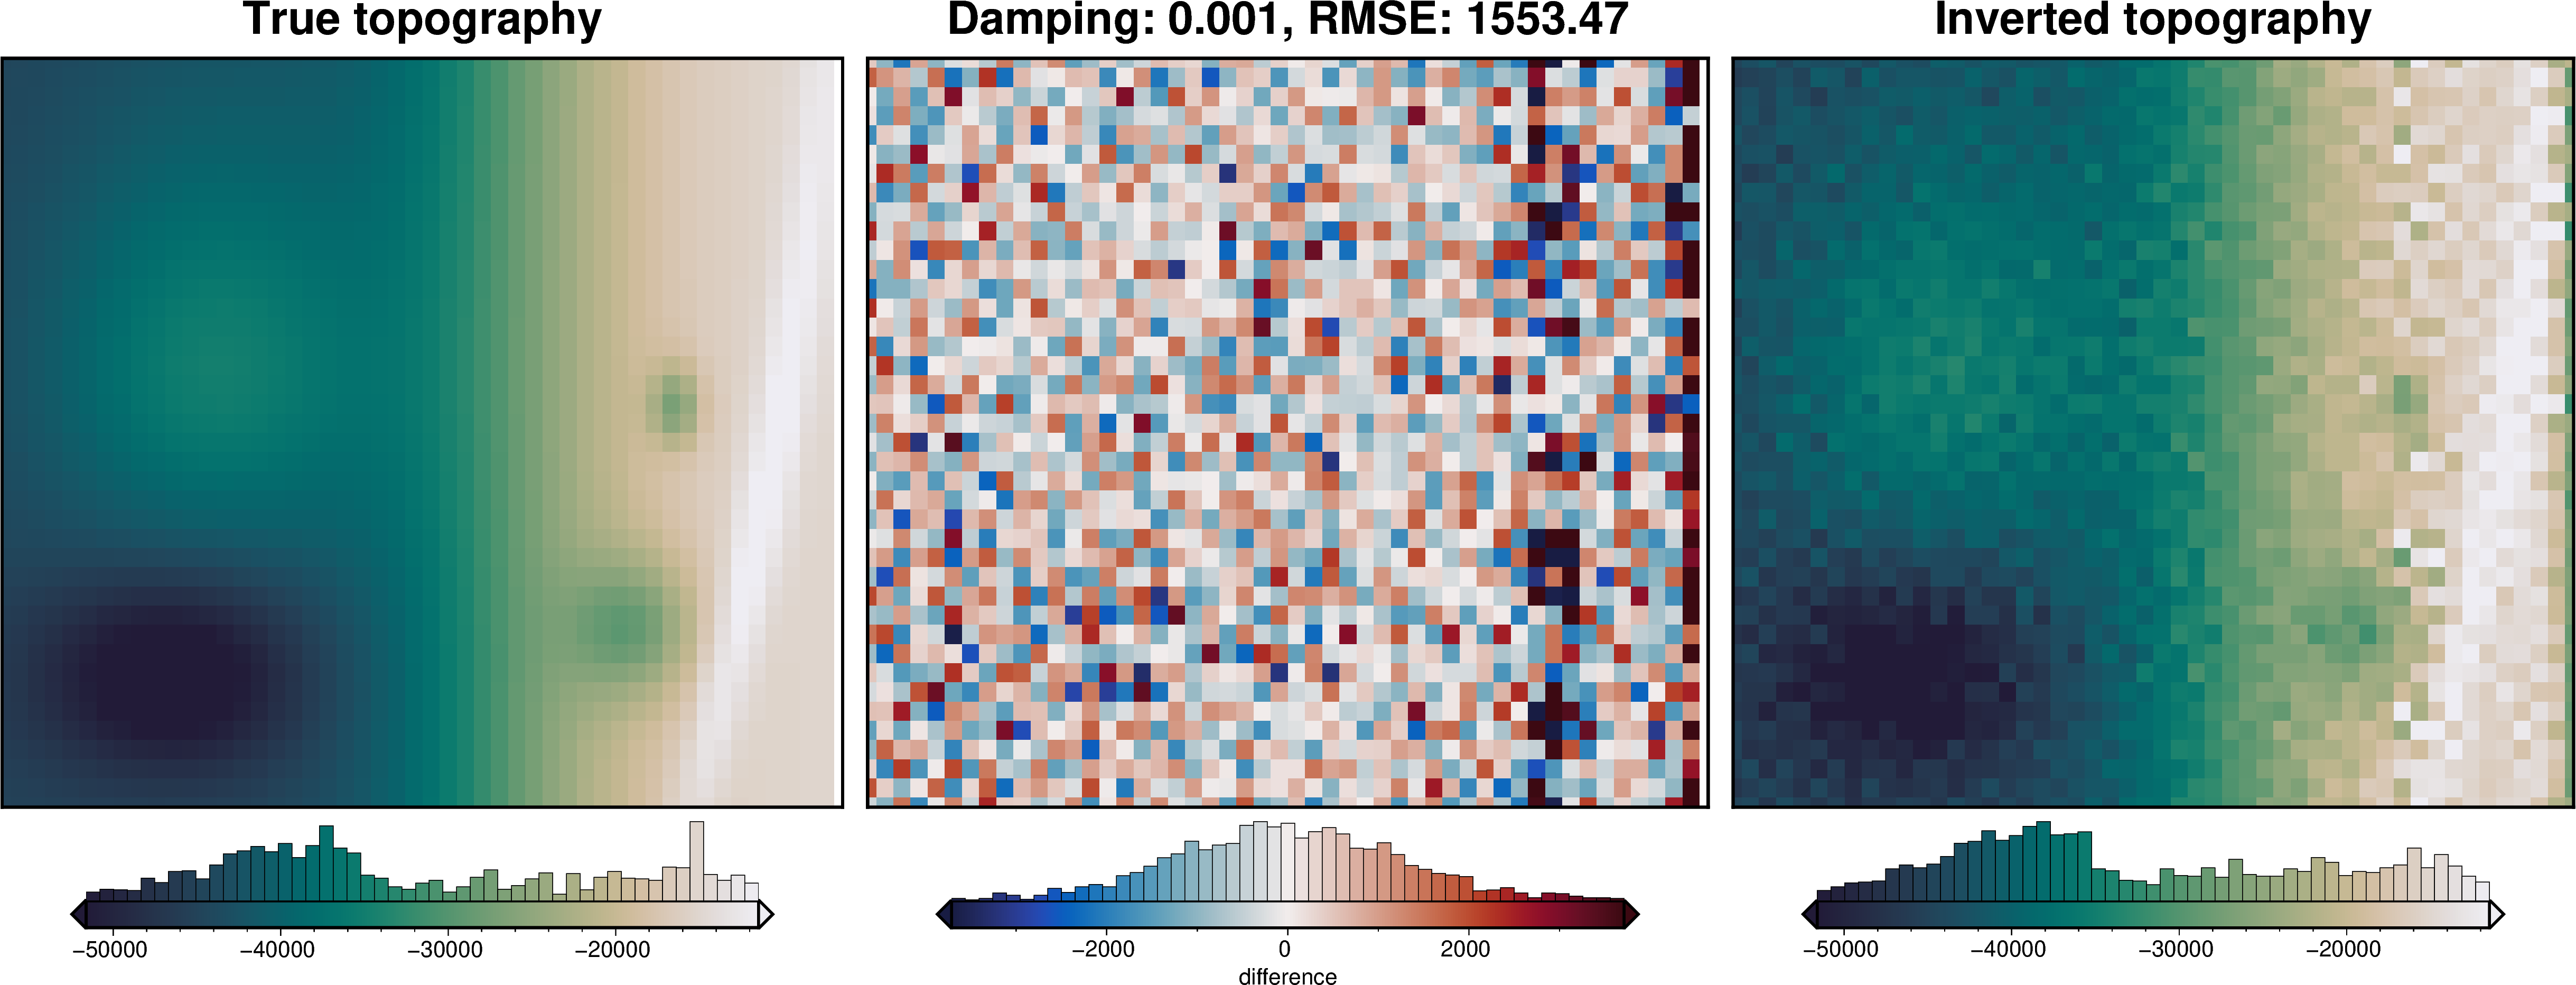

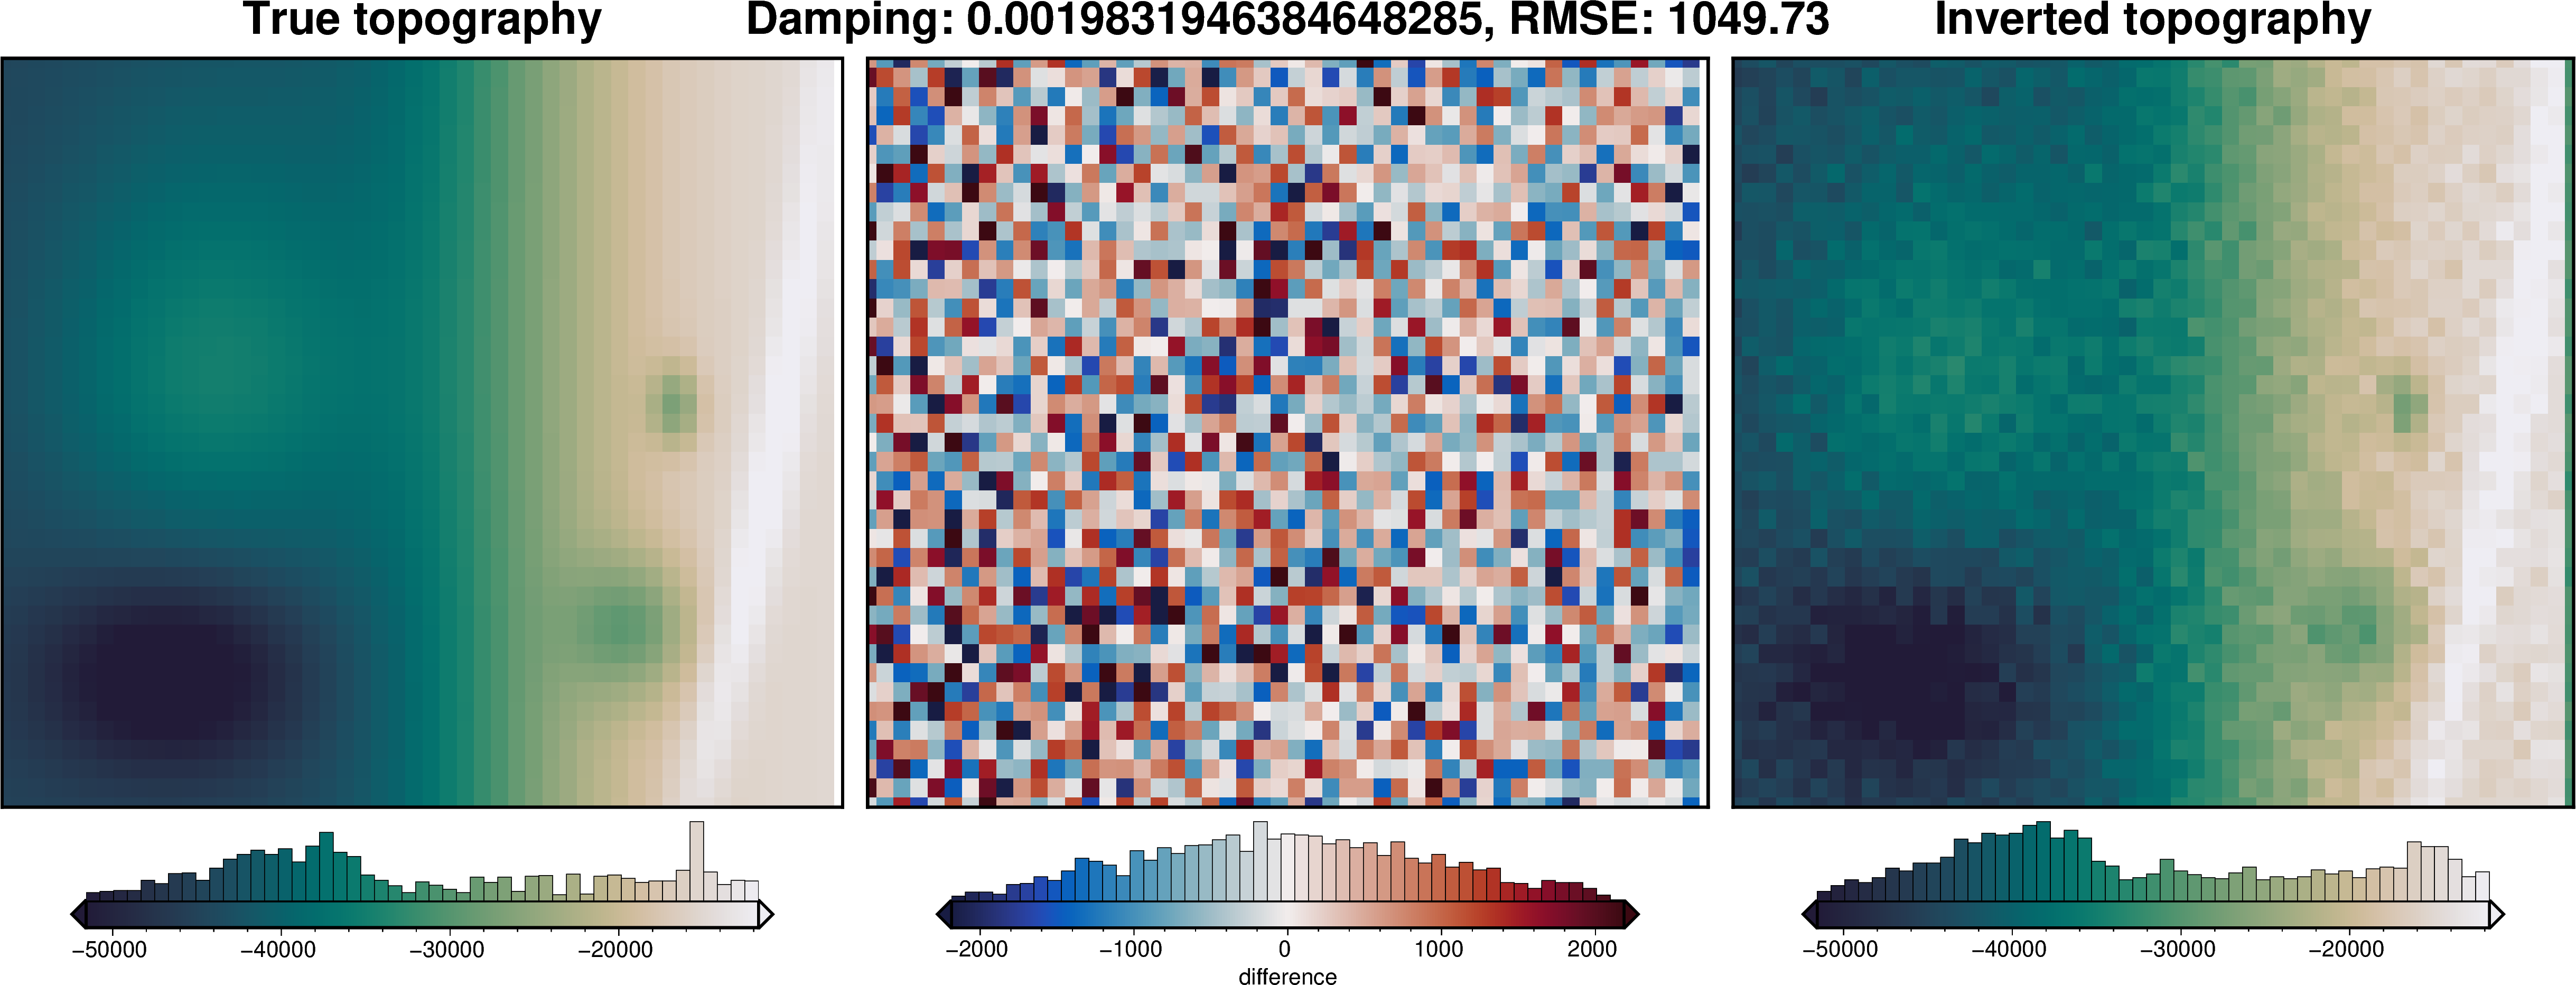

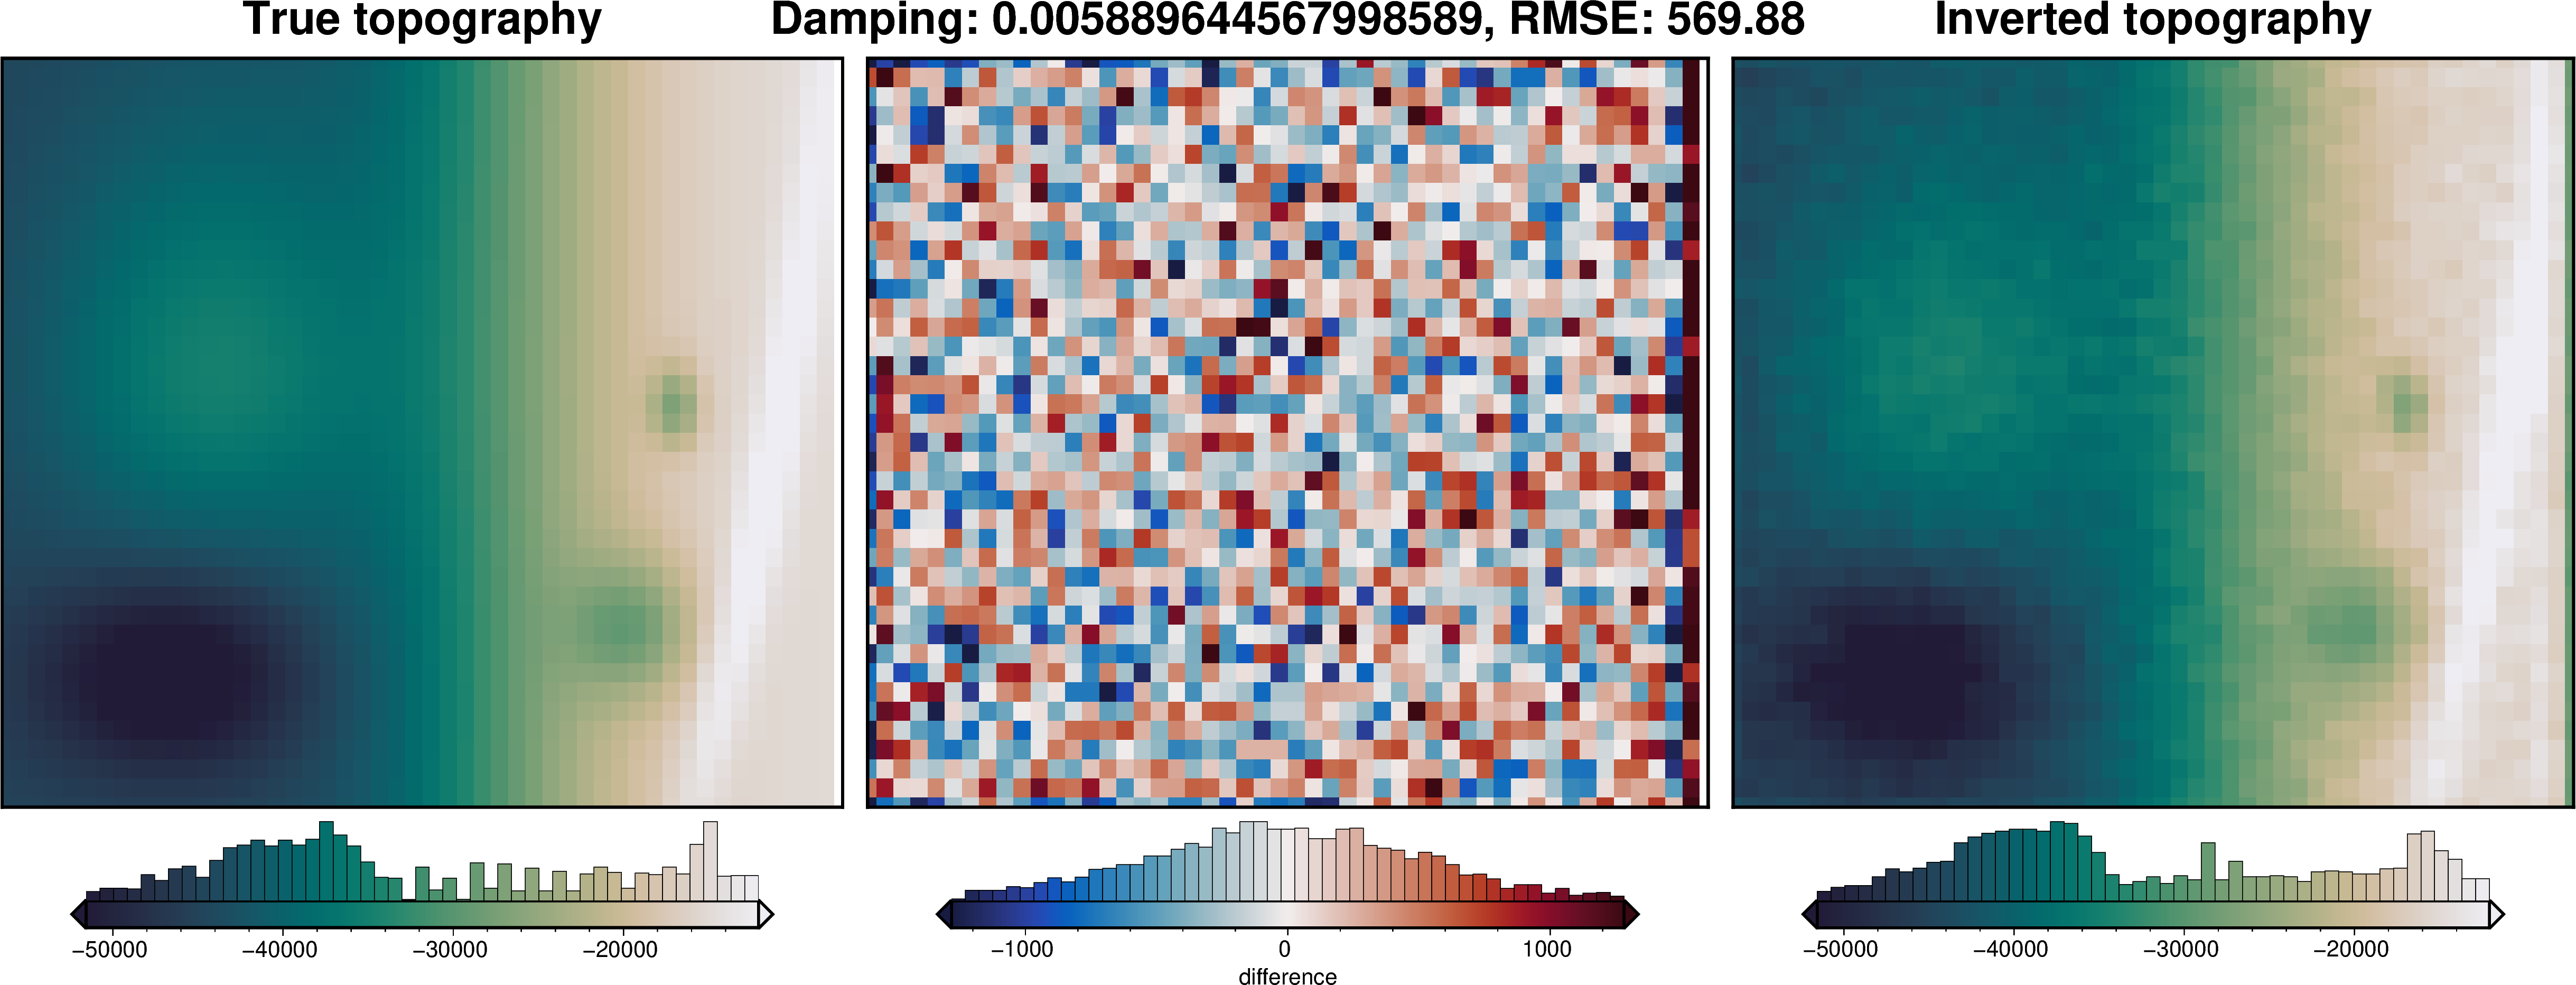

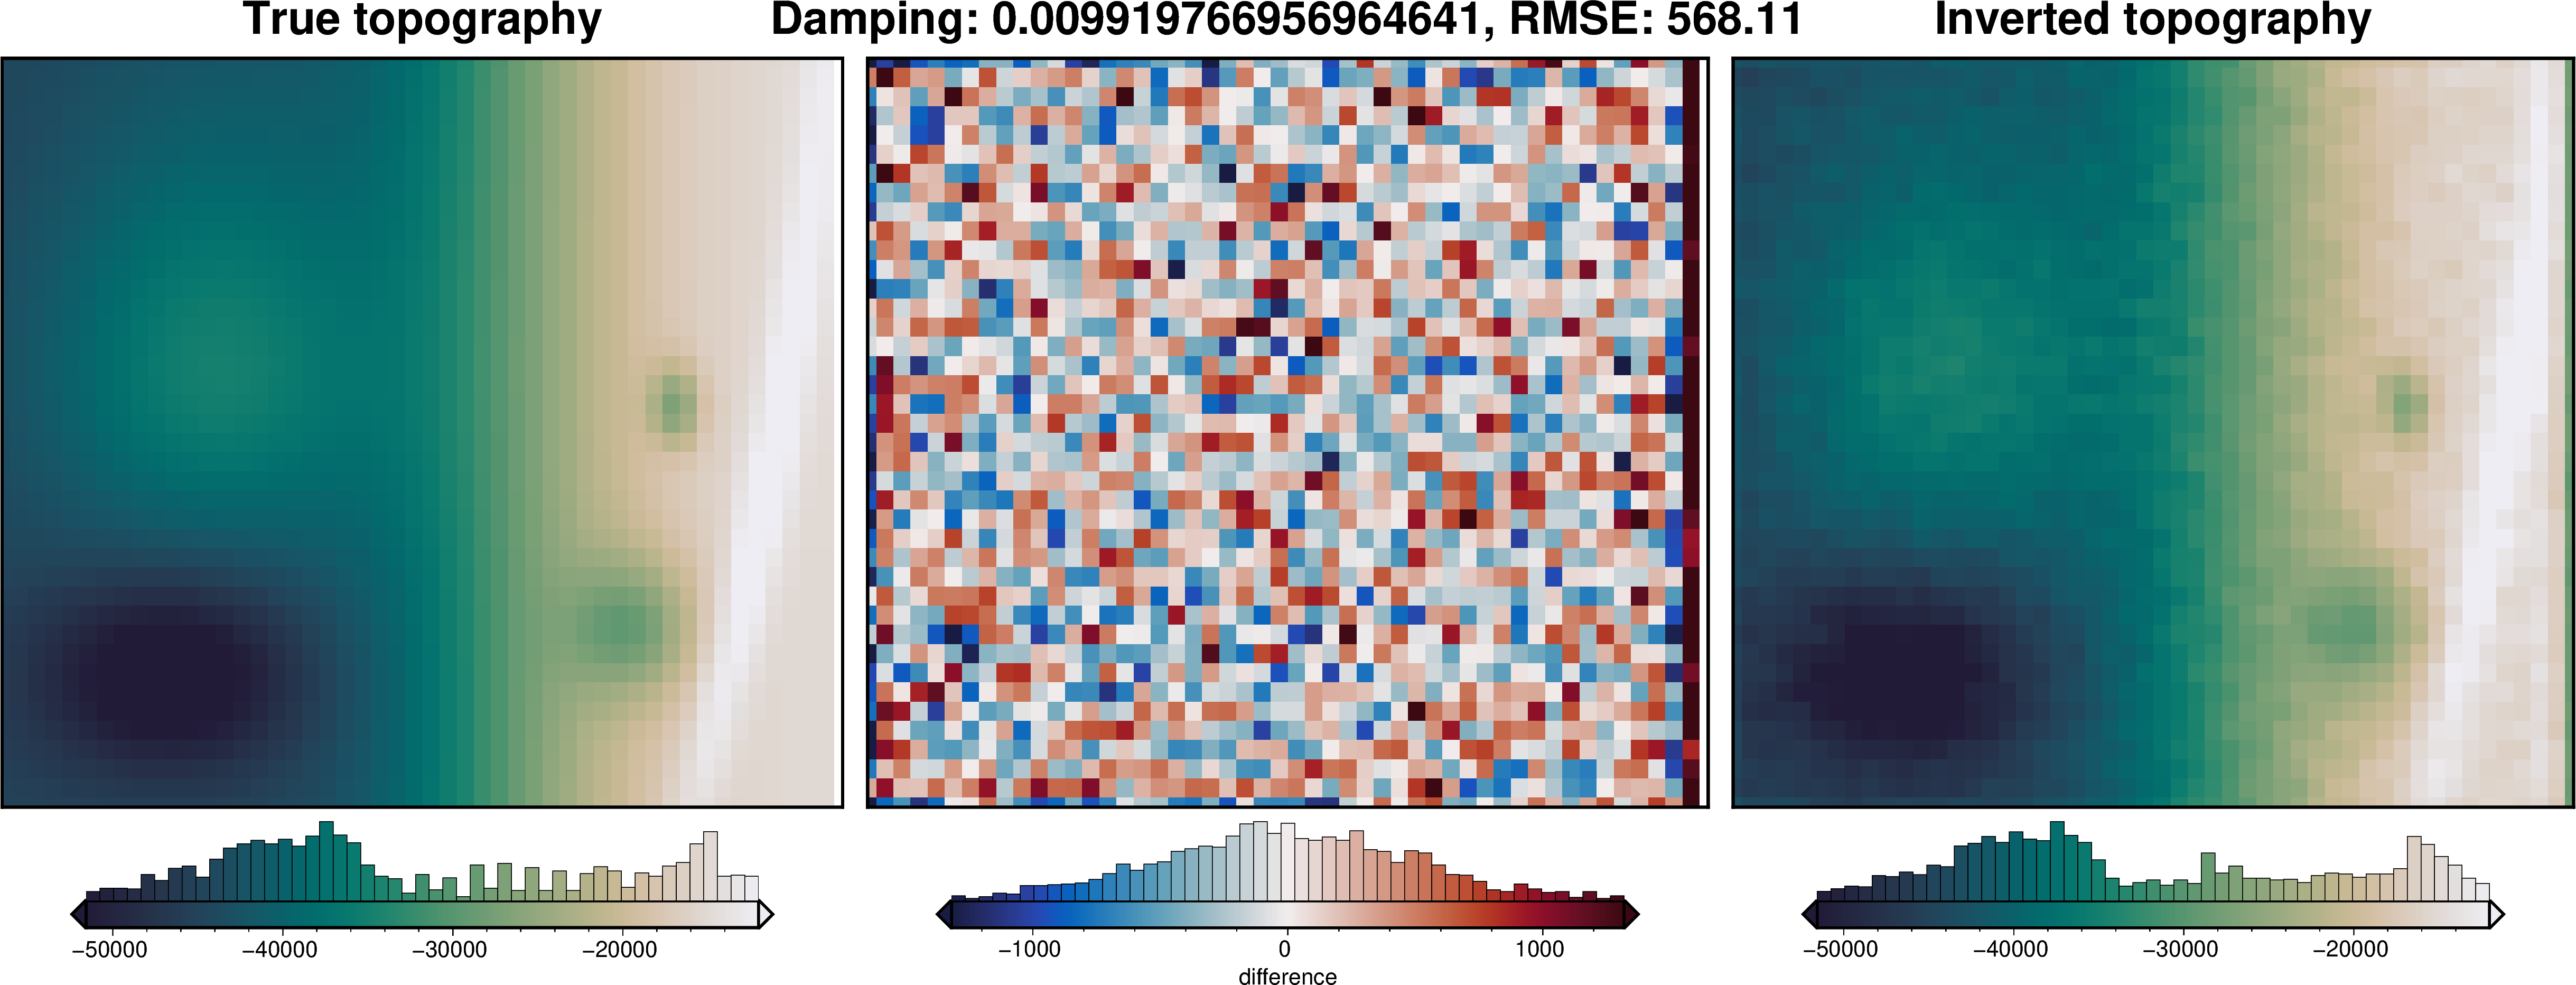

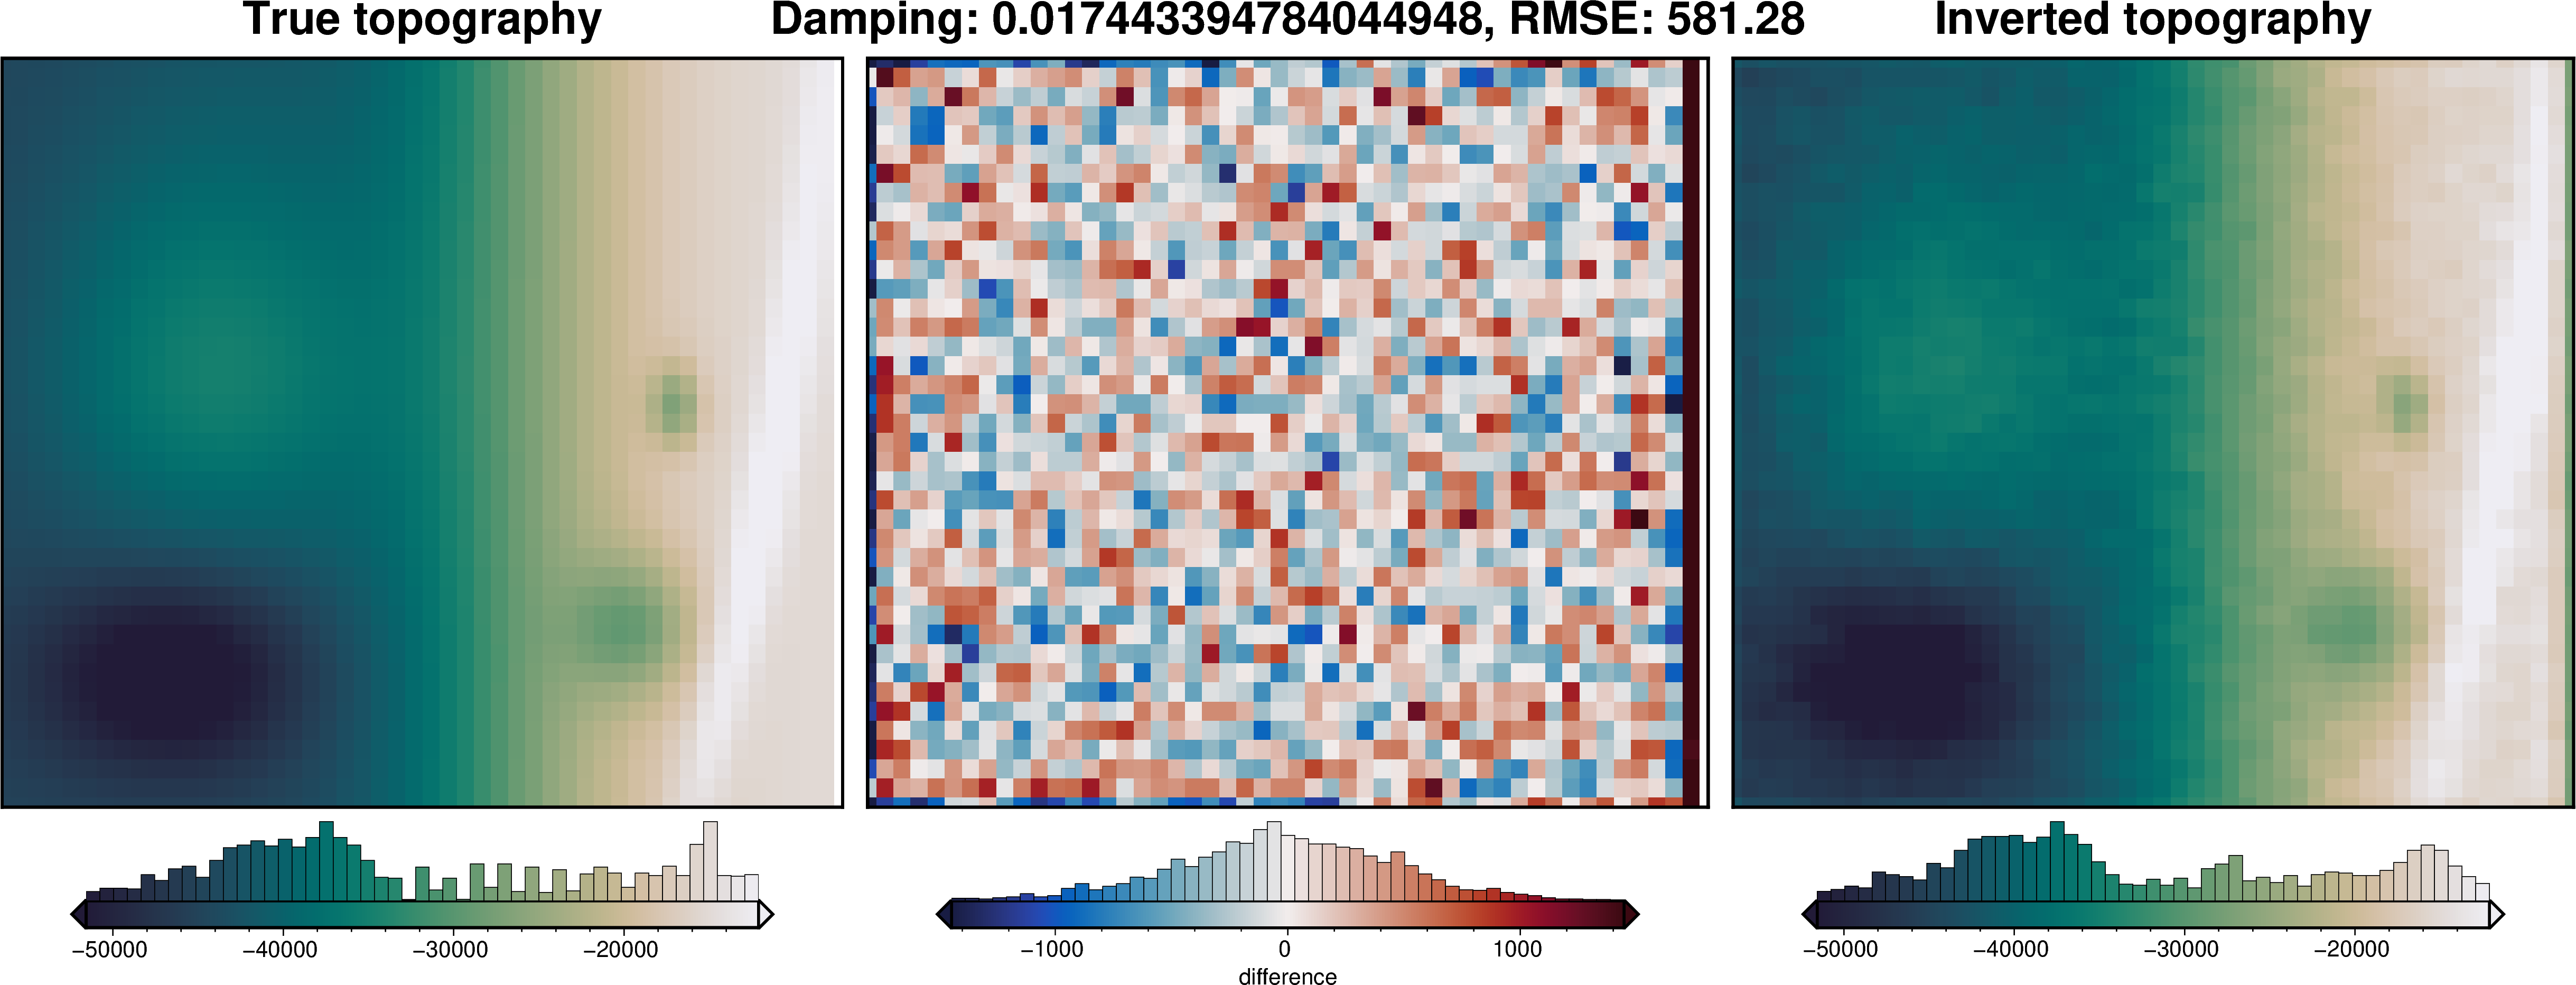

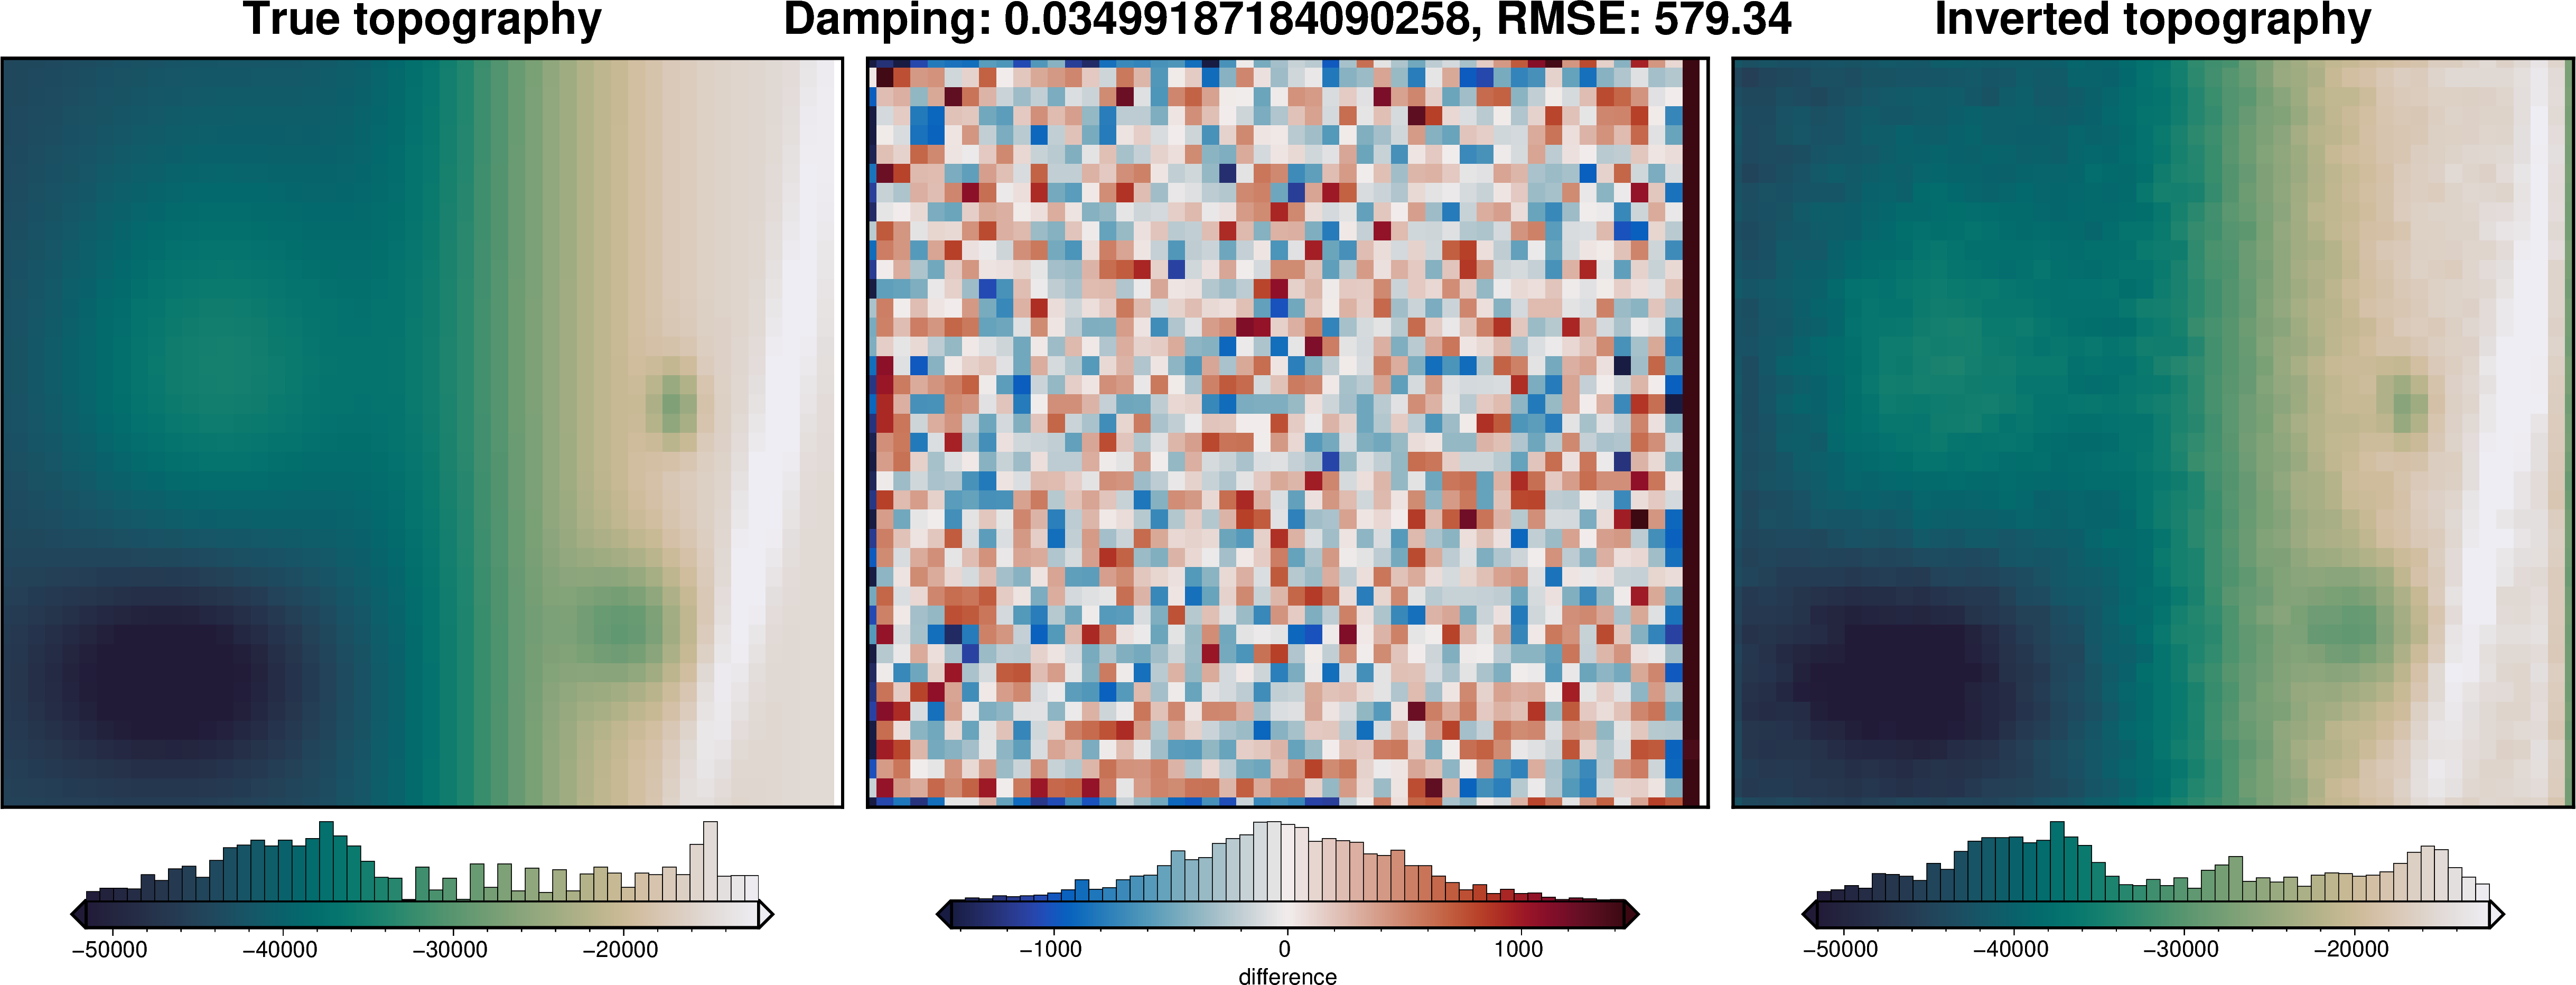

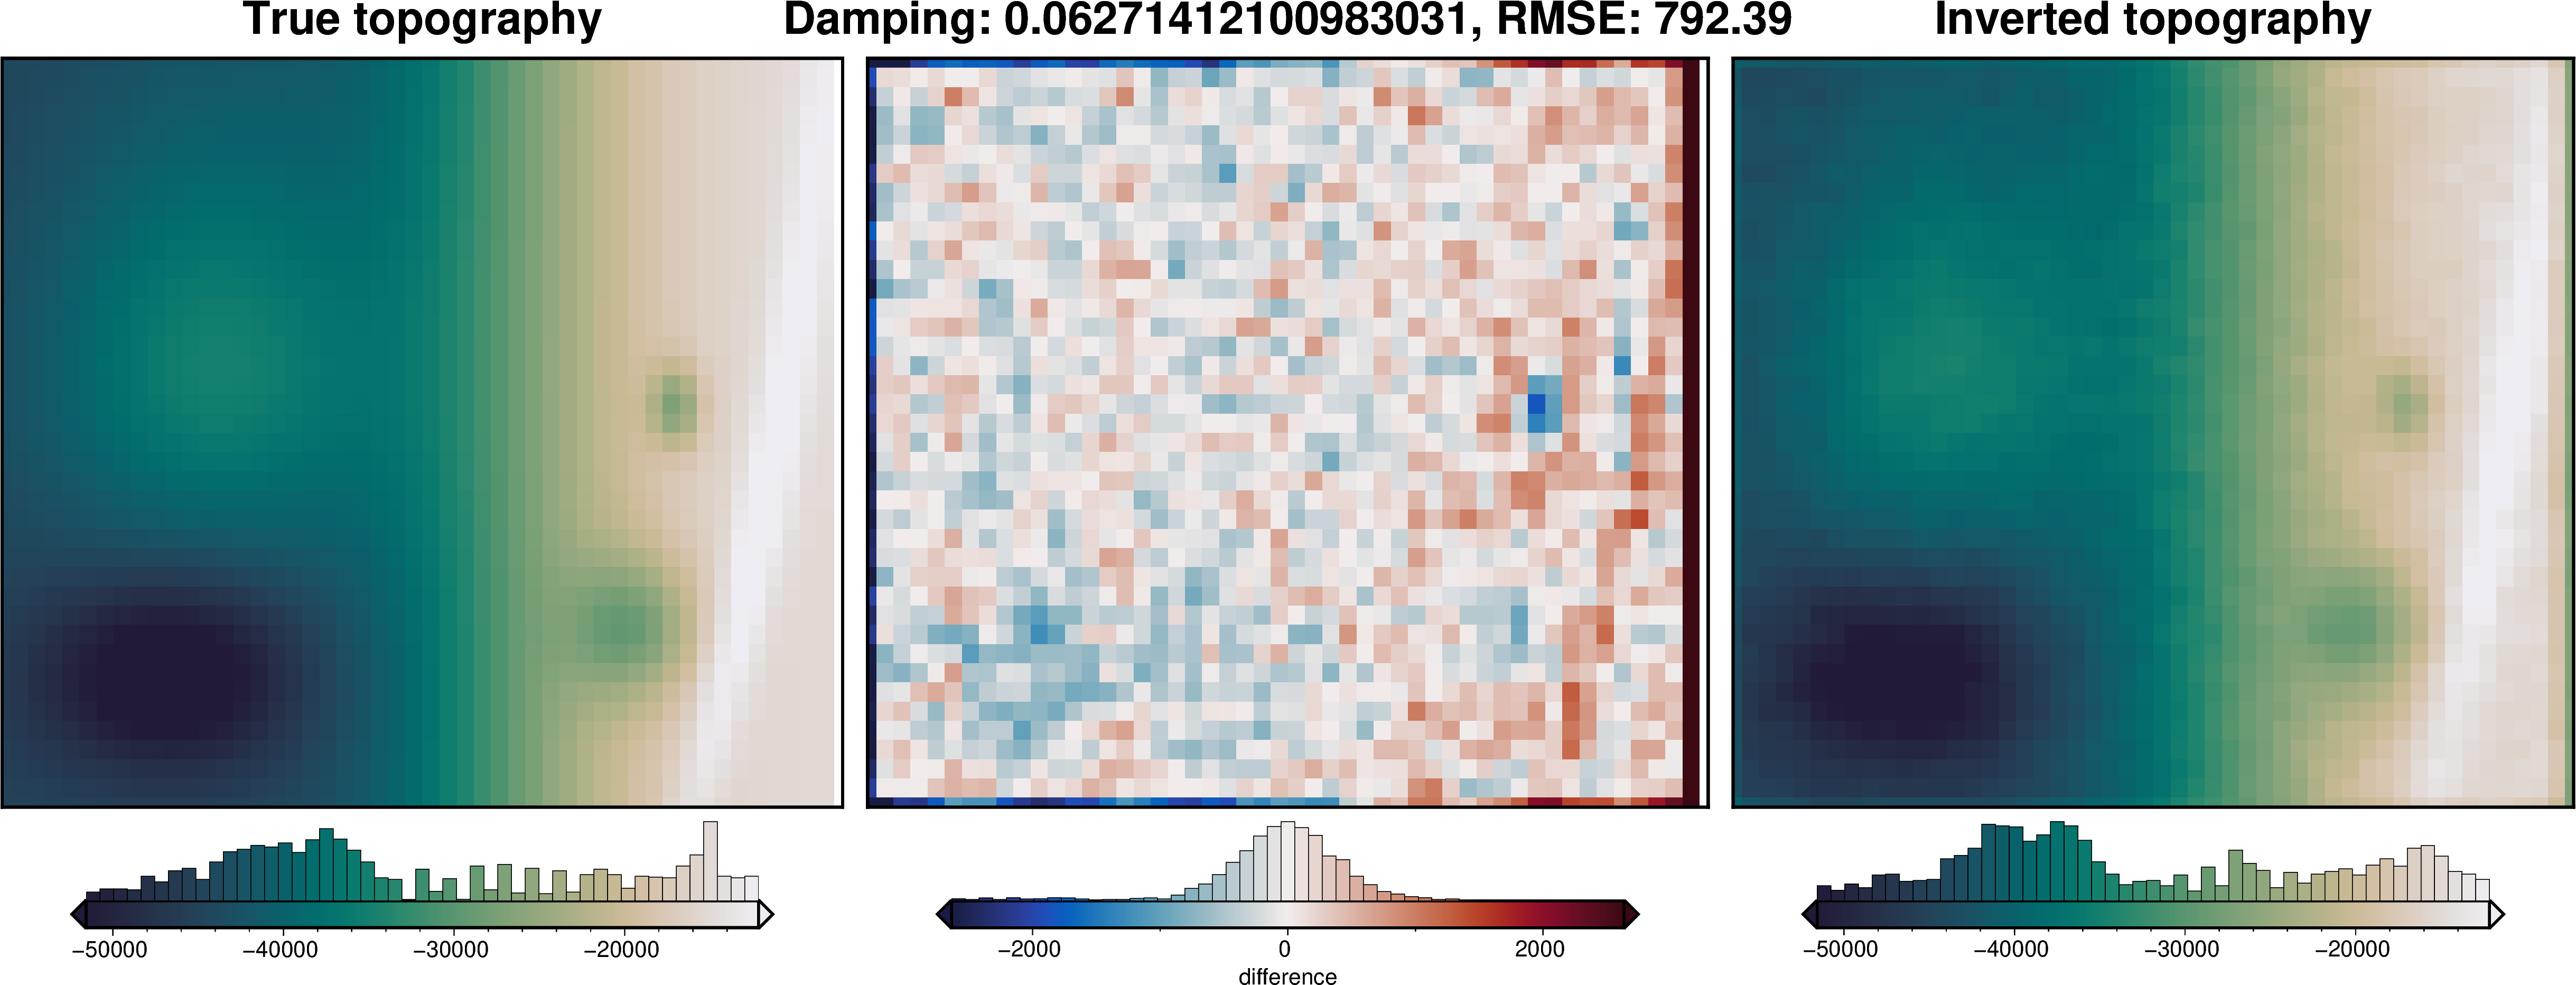

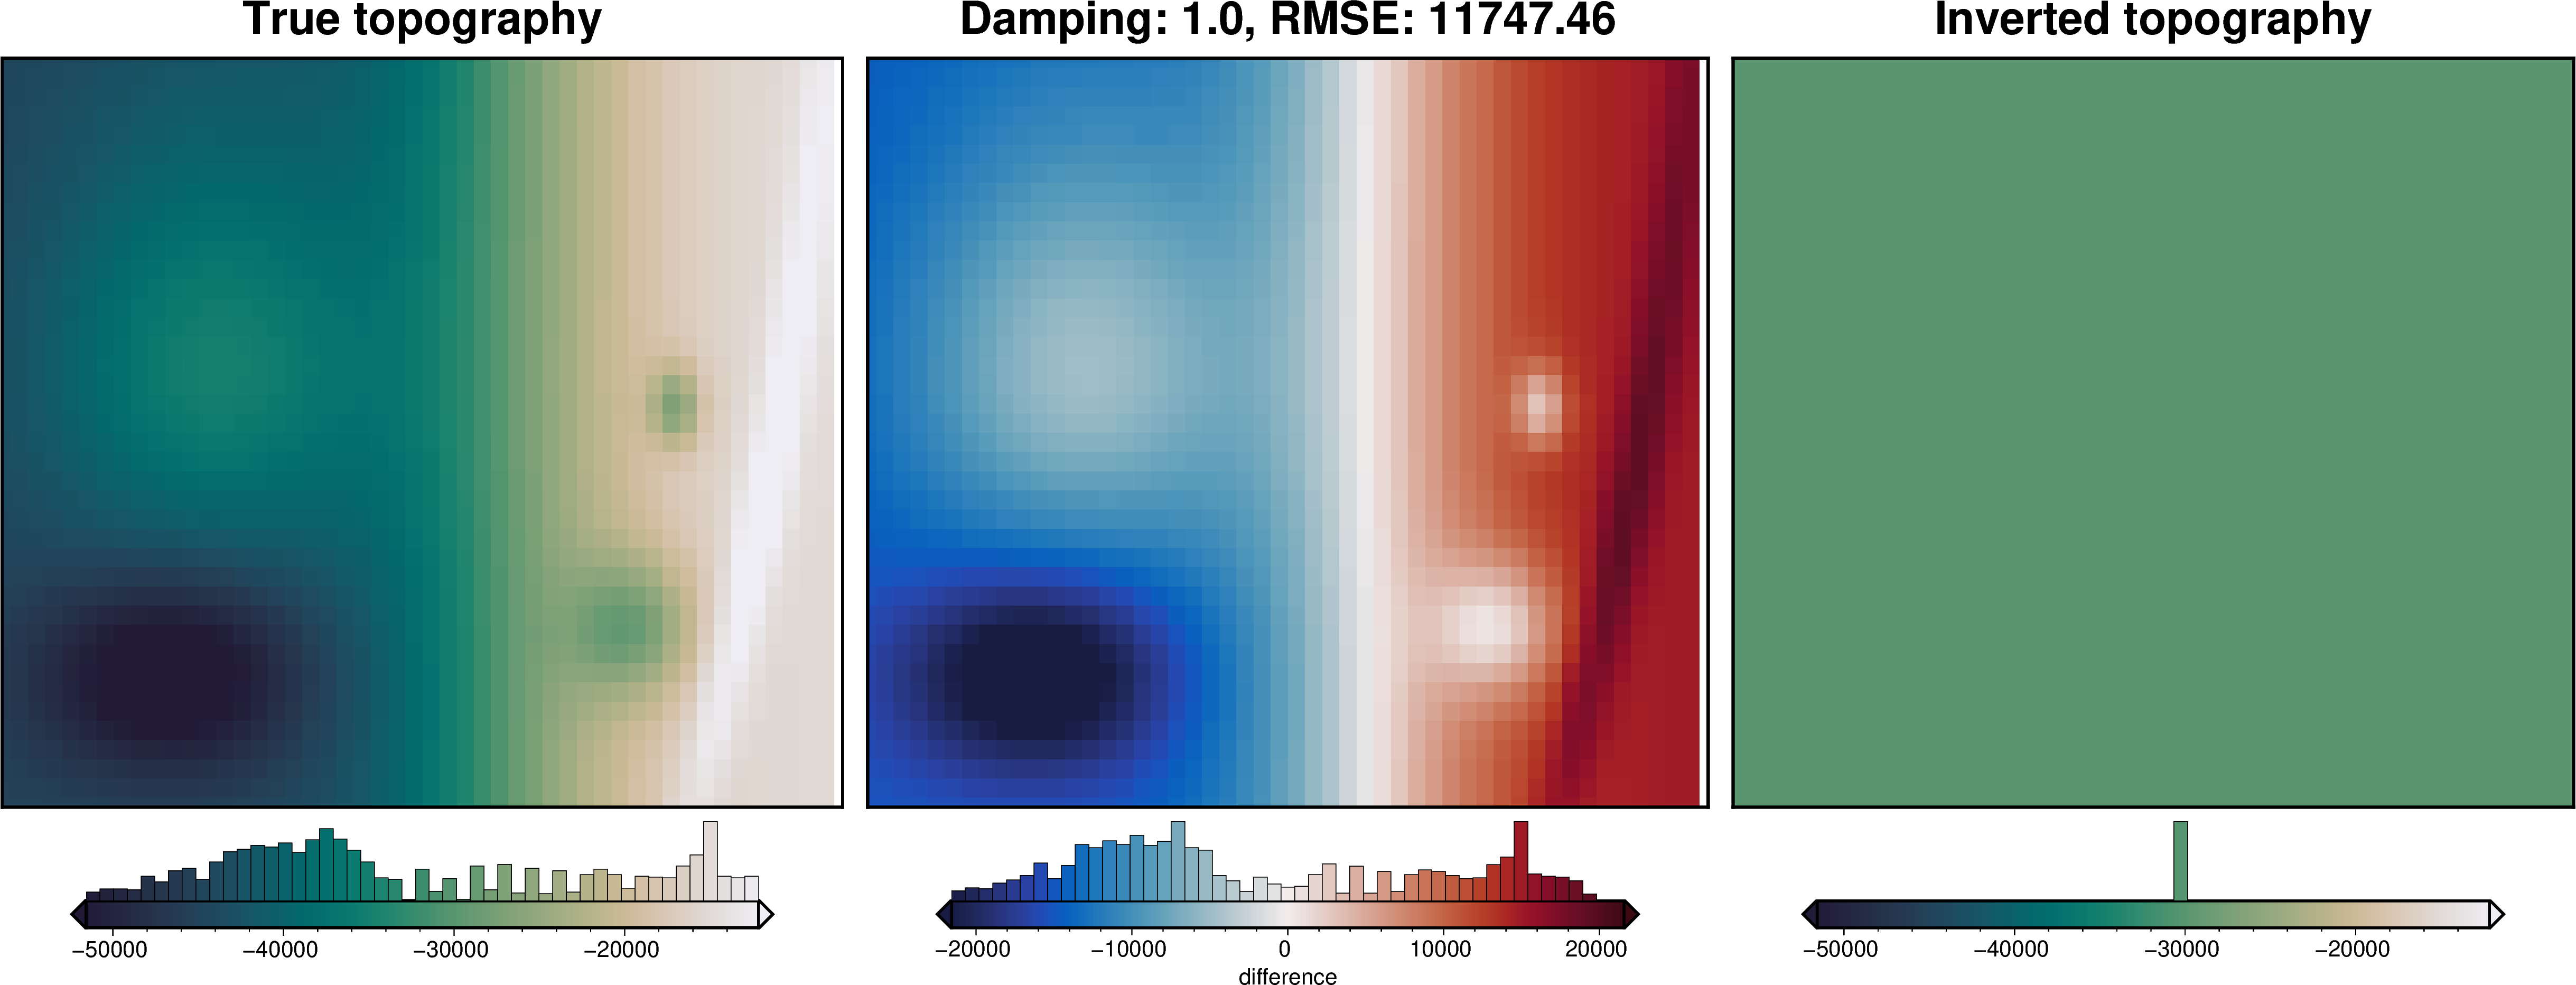

In [15]:
dampings = [
    (t.params["damping"], t.user_attrs["results"][0]) for t in study.get_trials()
]
dampings = sorted(dampings, key=lambda x: x[0])

for damp, df in dampings:
    final_topography = df.set_index(["northing", "easting"]).to_xarray().topo

    _ = polar_utils.grd_compare(
        true_moho,
        final_topography,
        plot=True,
        grid1_name="True topography",
        grid2_name="Inverted topography",
        robust=True,
        hist=True,
        inset=False,
        verbose="q",
        title=f"Damping: {damp}",
        grounding_line=False,
        reverse_cpt=True,
        cmap="rain",
    )

# Inversion results

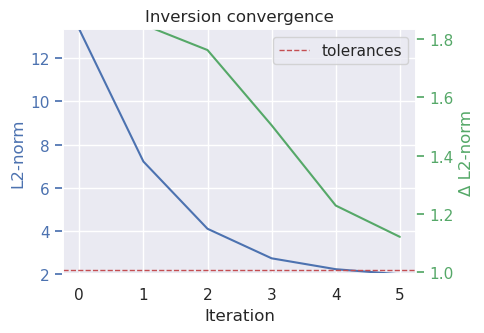

In [16]:
plotting.plot_convergence(
    grav_results,
    parameters,
)

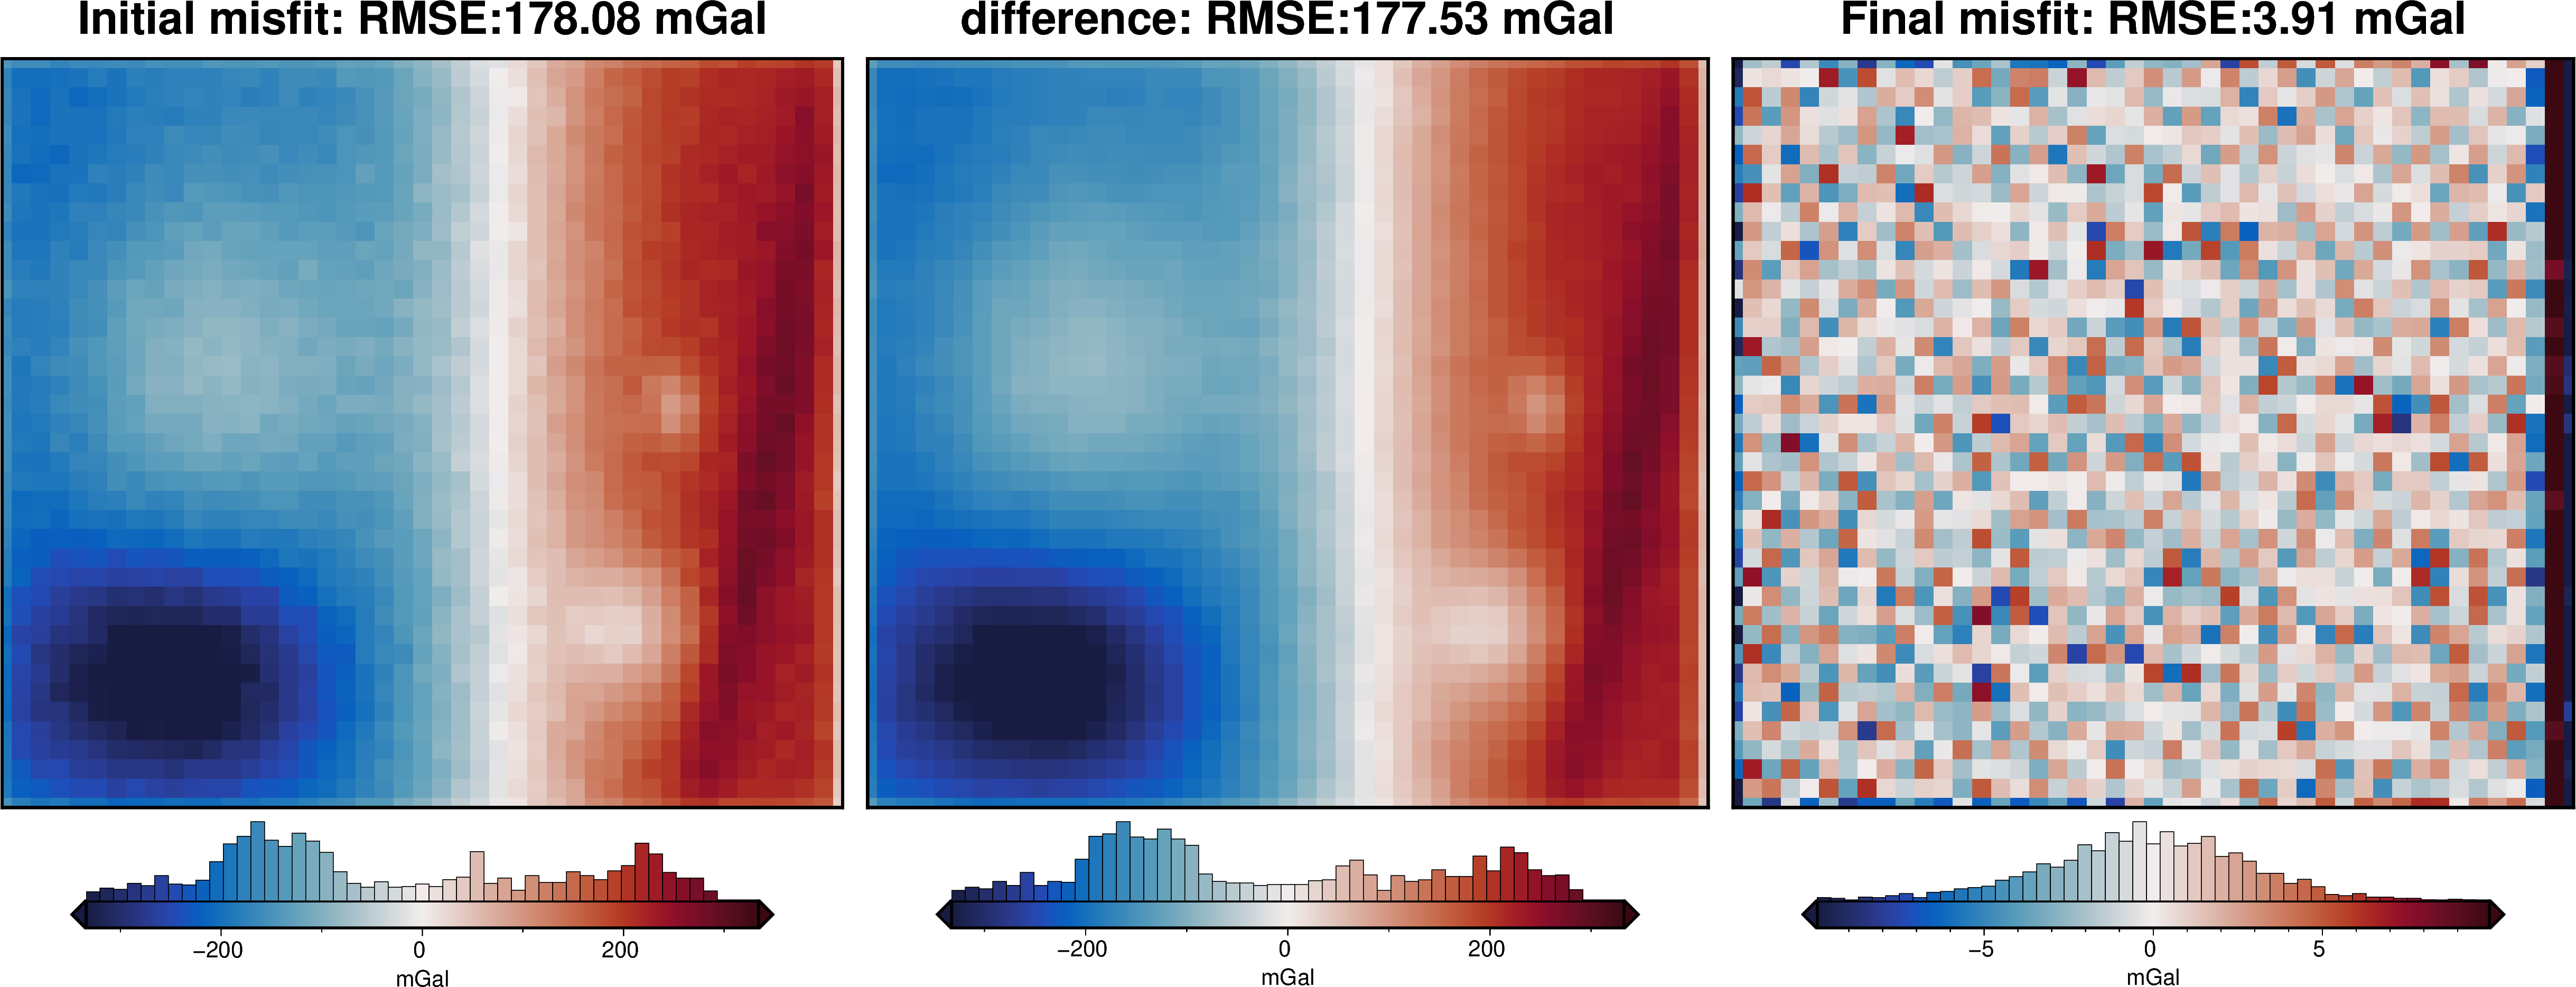

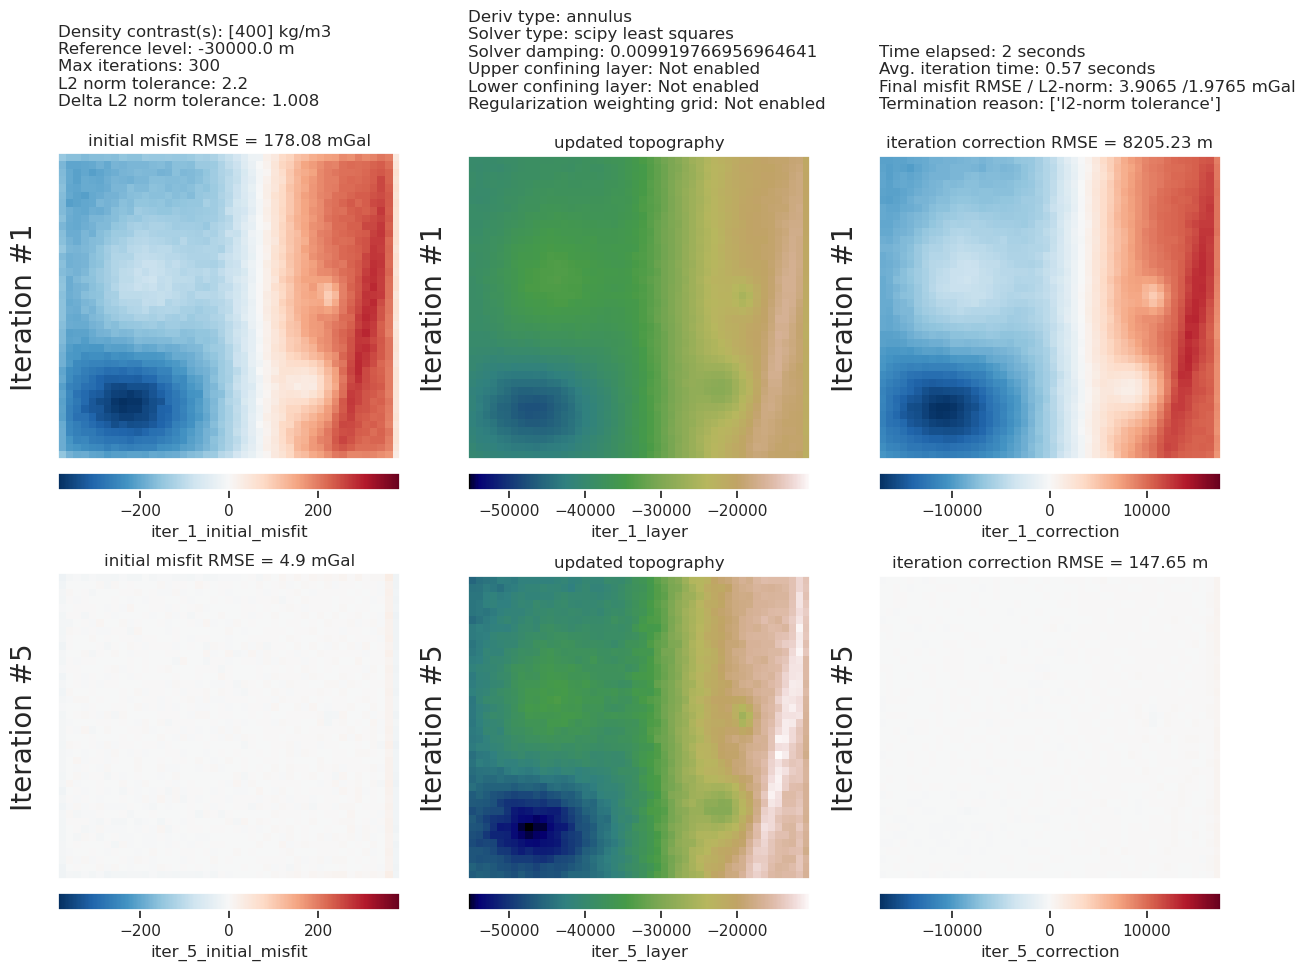

In [17]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=False,
    plot_grav_results=True,
)

The top plot above compares gravity misfit before and after the inversion. The right subplot is equivalent to Figure 5c in the paper. 

The lower plot shows the iteration results of the inversion, and has all the parameter values and metadata at the top. From this, you can see the inversion terminated after 2 iterations due to the inversion reaching the set L2-norm tolerance. 

# Compare inverted with true topography
The plot below shows how the inversion performed. In the title, you can see the root mean squared difference (RMSE) between the true moho topography and the inversion topography, and the colorbar histogram shows the distribution of the differences. 

The errors appear to be normally distributed around 0, with max and min values of around 2km. Ueida et al. 2017 reported max and min errors of 2.19 and 2.13km, showing the similar effectiveness of these two inversions.

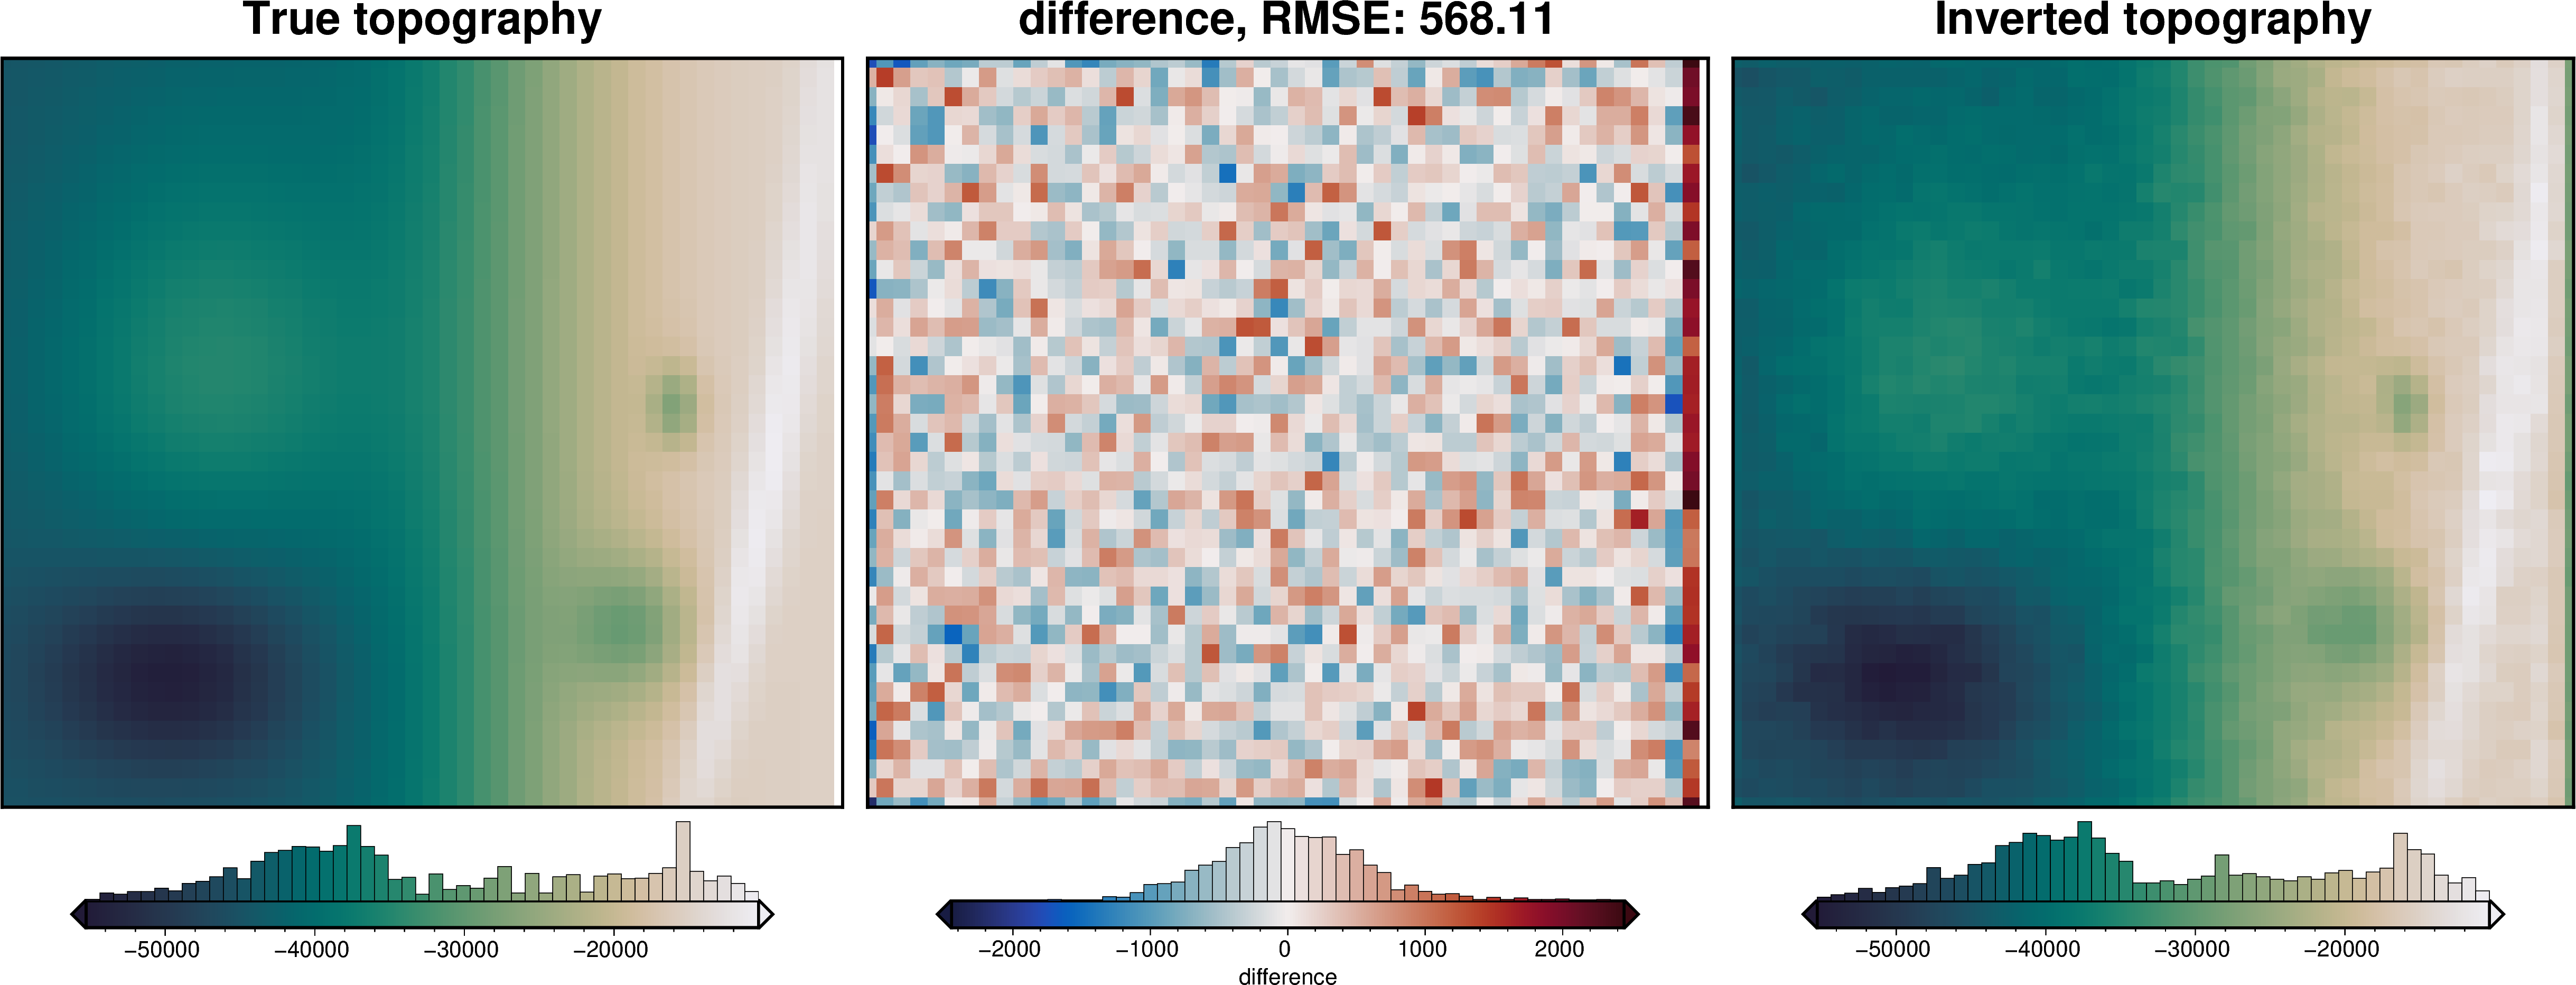

In [18]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_moho,
    final_topography,
    plot=True,
    region=region,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    # robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
)